# Regression Problem - AirBnB Price Prediction in 3 European Cities
Nightly pricing on Airbnb is a legitimate practice that hosts employ to stay competitive in the short-term rental market. By definition, pricing an Airbnb listing involves structuring rental costs in such a way that they might diverge from what is commonly expected, ultimately seeking to balance occupancy and profitability. The rapid expansion of Airbnb in key European tourism hubs—Barcelona, Paris, and Rome—has been driven by a combination of increased travel demand, liberalized local regulations in some areas, and advancements in technology-based marketplaces. These factors underscore the need to better understand the drivers of Airbnb pricing and how best to forecast them.

In this study, we will investigate whether it is possible to forecast, one year ahead, the average nightly price of Airbnb listings in Barcelona, Paris, and Rome using classic (or “shallow”) Machine Learning methods. As prior research in the short-term rental market suggests, this task is far from trivial.  Accurate predictions of nightly rates may be particularly beneficial not only for hosts aiming to set competitive prices, but also for policymakers and tourism boards monitoring housing market dynamics.

There are many proposed methods in the literature for measuring or defining Airbnb prices. One widely used approach is to track the actual nightly rate displayed on the platform at a given time. Although straightforward, this measure can vary significantly across high and low seasons, and might not always capture discounts or fees that apply only sporadically. Nonetheless, we will use the raw listing price as our key target (endogenous) variable in this study, as it represents the direct cost faced by travelers and the primary revenue source for hosts.

Therefore, the following evaluation metrics for the forecasting problem have been selected: Mean Absolute Error (MAE) and Root Mean Square Error (RMSE). This choice is deliberate: MAE provides a more interpretable measure of average error in currency units, while RMSE penalizes larger individual errors more strongly—an important consideration when trying to anticipate large price fluctuations in highly sought-after tourist seasons. Between these two, RMSE will be of primary importance, as extreme mispricing can have significant impacts on hosts’ income and market fairness.

Ultimately, this problem can be viewed as a form of panel data analysis (covering multiple listings over multiple time periods) that incorporates both cross-sectional and temporal aspects of Airbnb pricing. By exploring this domain, we hope to shed light on how short-term rental prices behave in these iconic European cities, and how Machine Learning can be used to forecast them more effectively.


## Dataset Description
This dataset provides a comprehensive look at Airbnb prices in some of the most popular European cities. Each listing is evaluated for various attributes such as room types, cleanliness and satisfaction ratings, bedrooms, distance from the city centre, and more to capture an in-depth understanding of Airbnb prices on both weekdays and weekends. Using spatial econometric methods, we analyse and identify the determinants of Airbnb prices across these cities.

Our dataset includes information such as:
- room_type- The type of room being offered (e.g. private, shared, etc.). (Categorical)
- room_shared- Whether the room is shared or not. (Boolean)
- room_private- Whether the room is private or not. (Boolean)
- person_capacity- The maximum number of people that can stay in the room. (Numeric)
- host_is_superhost- Whether the host is a superhost or not. (Boolean)
- multi- Whether the listing is for multiple rooms or not. (Boolean)
- biz- Whether the listing is for business purposes or not. (Boolean)
- cleanliness_rating- The cleanliness rating of the listing. (Numeric)
- guest_satisfaction_overall- The overall guest satisfaction rating of the listing. (Numeric)
- bedrooms- The number of bedrooms in the listing. (Numeric)
- dist- The distance from the city centre. (Numeric)
- metro_dist	The distance from the nearest metro station.- (Numeric)
- lng- The longitude of the listing. (Numeric)
- lat- The latitude of the listing. (Numeric)
- is_weekend- Whether the offer referred to weekdays or weekends (Boolean)
- city- city of Airbnb offer (Categorical)

Source: https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data
This project will cover panel data fro 3 cities (Barcelona, Paris, Rome)

### Load Dependencies

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy as bp
import os
import pickle

import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    make_scorer
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)

from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from additional_functions import feature_selection, scoring_wrapper
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [5]:
df_barcelona = pd.read_csv("data/output/barcelona.csv")
df_paris = pd.read_csv("data/output/paris.csv")
df_rome = pd.read_csv("data/output/rome.csv")
df = pd.read_csv("data/output/DATA.csv")

## Global Model

### Data Preparation

In [6]:
df

realSum        room_type  room_shared  room_private  \
0      474.317499  Entire home/apt        False         False   
1      169.897829     Private room        False          True   
2      161.984779     Private room        False          True   
3      367.956804  Entire home/apt        False         False   
4      196.895292     Private room        False          True   
...           ...              ...          ...           ...   
18543  413.812452  Entire home/apt        False         False   
18544  582.376733  Entire home/apt        False         False   
18545  878.591635  Entire home/apt        False         False   
18546  447.244757  Entire home/apt        False         False   
18547  265.821897  Entire home/apt        False         False   

       person_capacity  host_is_superhost  multi  biz  cleanliness_rating  \
0                  4.0              False      0    1                10.0   
1                  2.0               True      1    0                10.0   
2                  4.0              False      0    1                 9.0   
3                  3.0              False      0    1                10.0   
4                  3.0              False      1    0                 9.0   
...                ...                ...    ...  ...                 ...   
18543              4.0              False      0    1                10.0   
18544              6.0               True      0    1                10.0   
18545              6.0               True      1    0                10.0   
18546              4.0               True      1    0                10.0   
18547              6.0              False      0    1                10.0   

       guest_satisfaction_overall  bedrooms      dist  metro_dist  \
0                            91.0         1  1.111996    0.630491   
1                            88.0         1  1.751839    0.124017   
2                            88.0         1  1.670493    0.080322   
3                            91.0         1  1.475847    0.093107   
4                            91.0         1  1.855452    0.272486   
...                           ...       ...       ...         ...   
18543                        97.0         1  1.933569    0.270592   
18544                        96.0         2  3.124166    1.939505   
18545                        99.0         3  2.759242    1.195339   
18546                        98.0         1  1.641598    0.858837   
18547                        96.0         2  4.411877    0.352493   

        attr_index  attr_index_norm   rest_index  rest_index_norm       lng  \
0       526.469420        17.942927   915.587083        20.154890   2.17556   
1       320.127526        10.910462   794.277350        17.484489   2.14906   
2       344.073936        11.726595   840.673617        18.505814   2.15357   
3       400.057449        13.634603   946.589884        20.837357   2.16839   
4       346.042245        11.793678   792.296039        17.440874   2.15238   
...            ...              ...          ...              ...       ...   
18543   657.307139        14.562931  1408.407648        30.685786  12.48137   
18544   540.341368        11.971503  1985.435361        43.257820  12.46700   
18545   759.369097        16.824159  1783.268631        38.853097  12.46900   
18546  1125.857244        24.943866  1687.895816        36.775155  12.48342   
18547   167.701907         3.715510   467.340278        10.182211  12.53000   

            lat  is_weekend       City  
0      41.39624           0  Barcelona  
1      41.38714           0  Barcelona  
2      41.37859           0  Barcelona  
3      41.37390           0  Barcelona  
4      41.37699           0  Barcelona  
...         ...         ...        ...  
18543  41.90860           1       Rome  
18544  41.89100           1       Rome  
18545  41.90100           1       Rome  
18546  41.89634           1       Rome  
18547  41.86700           1       Rome  

[18548 rows x 21 columns]

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

We transform the data in the following way:

In [8]:
#Change of boolean variables into integers
df_train["is_weekend"]= df_train["is_weekend"].astype(int)
df_train["room_shared"]= df_train["room_shared"].astype(int)
df_train["room_private"]= df_train["room_private"].astype(int)
df_train["host_is_superhost"]= df_train["host_is_superhost"].astype(int)

#Change of object variables into categorical
df_train['room_type'] = df_train['room_type'].map({'Private room': 1,'Entire home/apt':2}).fillna(3)
df_train["room_type"]= df_train["room_type"].astype(int)
df_train.room_type.isna().sum()

#Dropping out initial indices as we have standardized forms
df_train=df_train.drop(columns=["attr_index", 'attr_index_norm'])
df_train=df_train.drop(columns=["rest_index", 'rest_index_norm'])

df_train['City'] = df_train['City'].map({'Barcelona': 1,'Paris':2, 'Rome':3})

Let's check the histograms of the variables in the dataset.

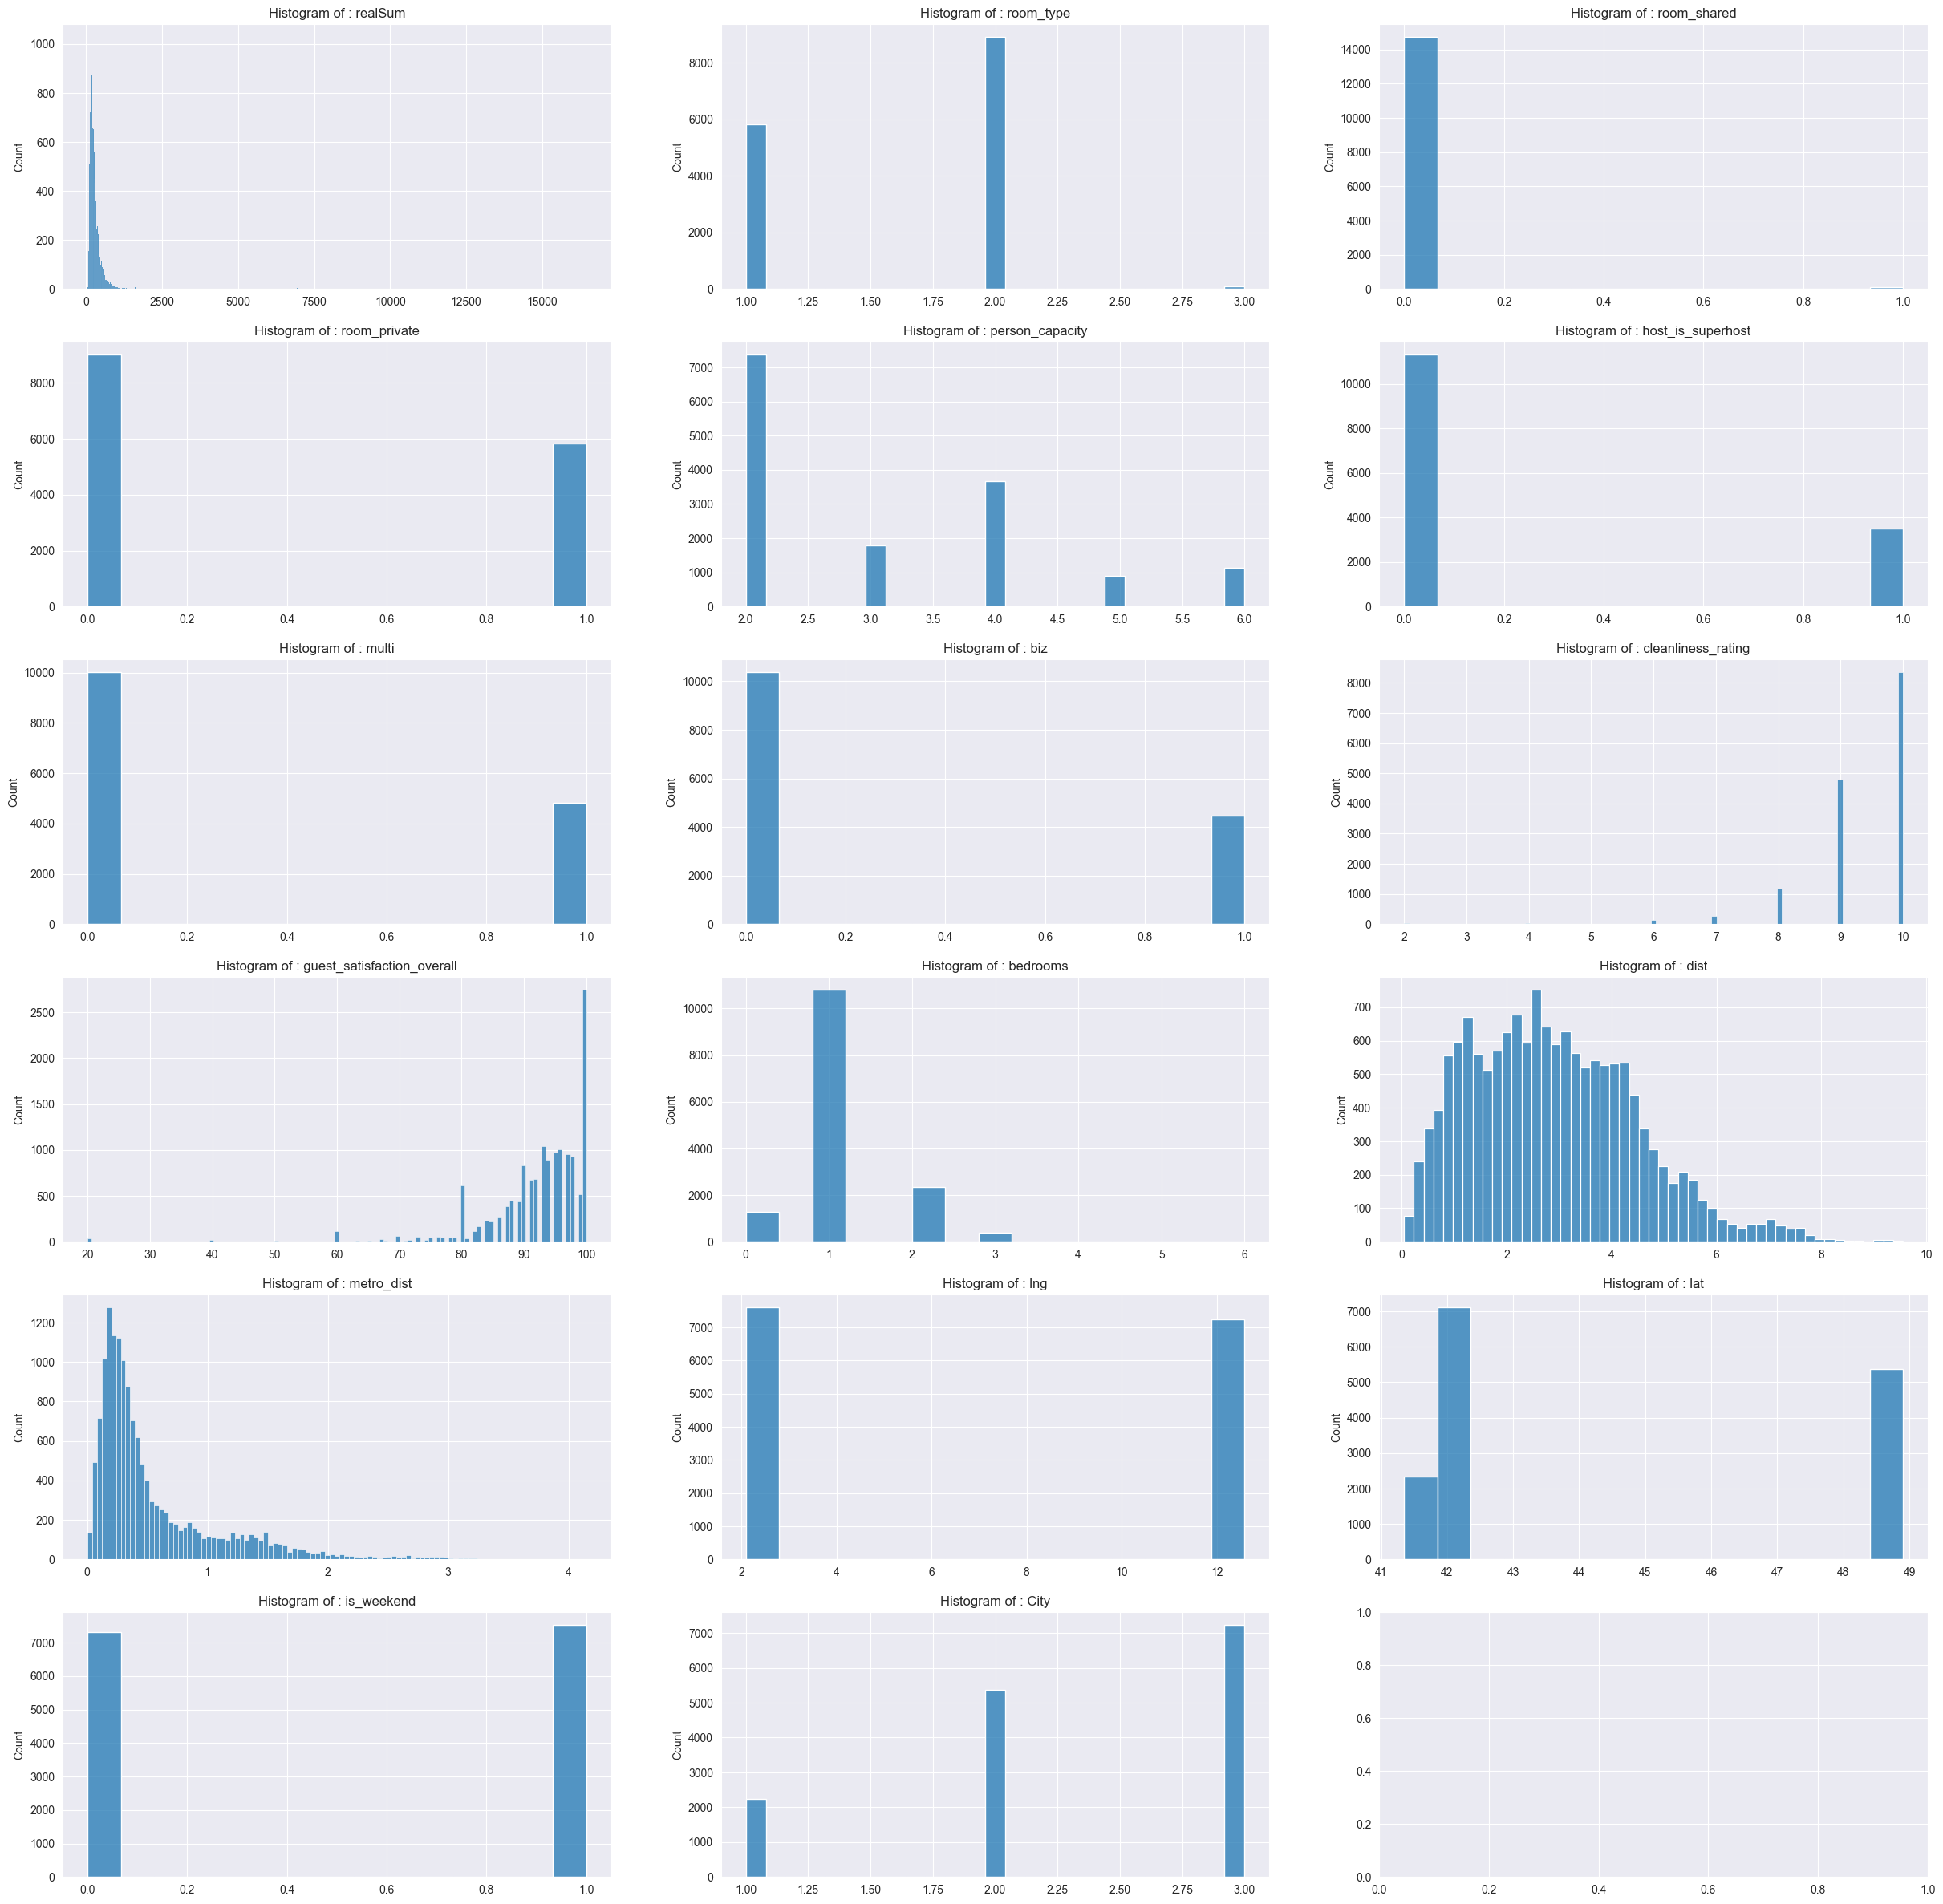

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(30, 30))
for i, ax in zip(df_train.columns, axes.flat):
    sns.histplot(x=df_train[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

From the histograms, we can see that:
- target variable needs to be transformed - it is right-skewed;
- type 3 in the variable "room_type" is insignificant - we can transform it to the binary discrete variable;
- less than 100 of listings are shared rooms, which is insignificant for the whole dataset (14838 records);
- "cleanlines_rating" and "guest_satisfaction_rating" are concentrated in the left half of the histogram - we can change the range of the spectrum.

Let's check the correlation between the variables.

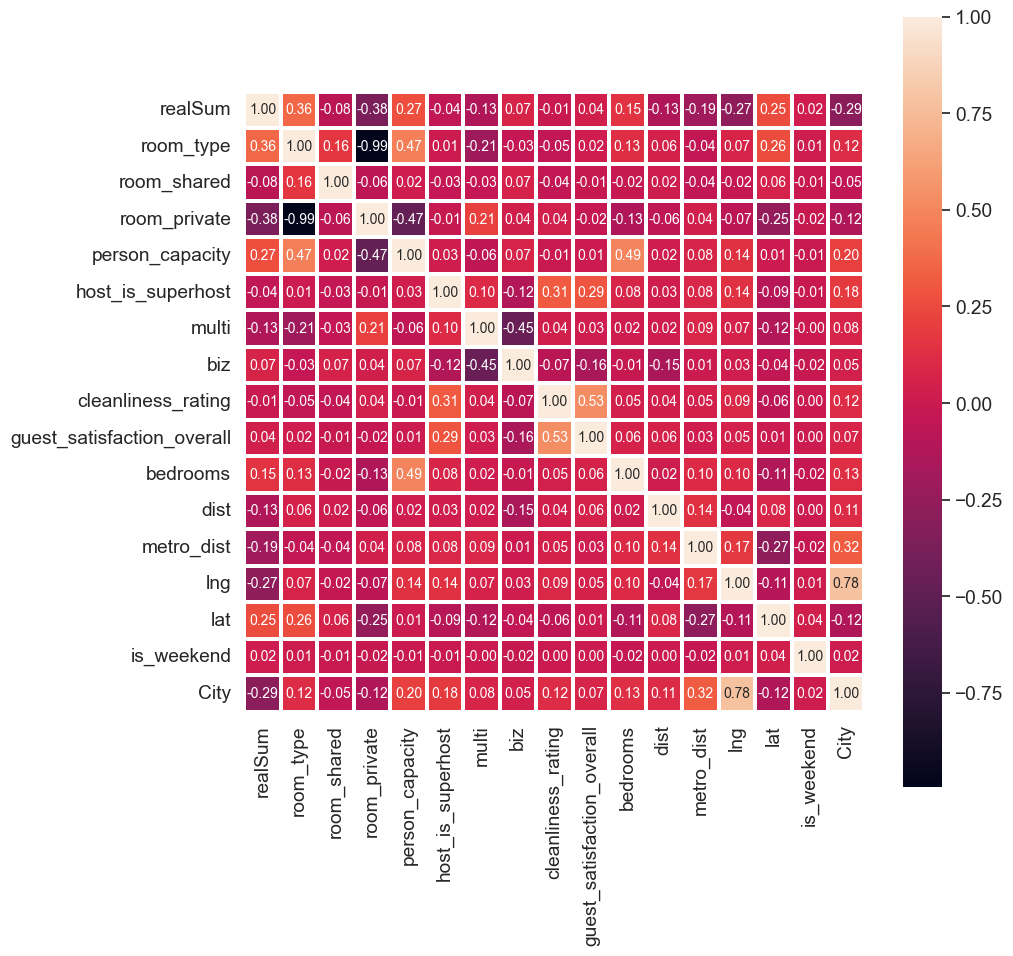

In [14]:
corr = df_train.corr(method="kendall")

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(
    corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
)
plt.show()

#### Target variable transformation

In [18]:
df_train.realSum.describe()

count    14838.000000
mean       285.849348
std        276.677124
min         46.057092
25%        161.984779
50%        225.375821
75%        332.394267
max      16445.614689
Name: realSum, dtype: float64

In [19]:
{i: df_train.realSum.quantile(i) for i in np.arange(0.9, 1.0, 0.01)}

{np.float64(0.9): np.float64(500.1666722911209),
 np.float64(0.91): np.float64(520.6056016566831),
 np.float64(0.92): np.float64(546.891602199646),
 np.float64(0.93): np.float64(573.4458010998229),
 np.float64(0.9400000000000001): np.float64(606.6129182589236),
 np.float64(0.9500000000000001): np.float64(648.9770714884891),
 np.float64(0.9600000000000001): np.float64(697.0733525957701),
 np.float64(0.9700000000000001): np.float64(767.9056019736175),
 np.float64(0.9800000000000001): np.float64(877.5505891047775),
 np.float64(0.9900000000000001): np.float64(1093.9818314637434)}

In [20]:
cutoff_realSum = df_train.realSum.quantile(0.99)
df_train['realSum_Cut']=df_train['realSum'].clip(upper=cutoff_realSum)

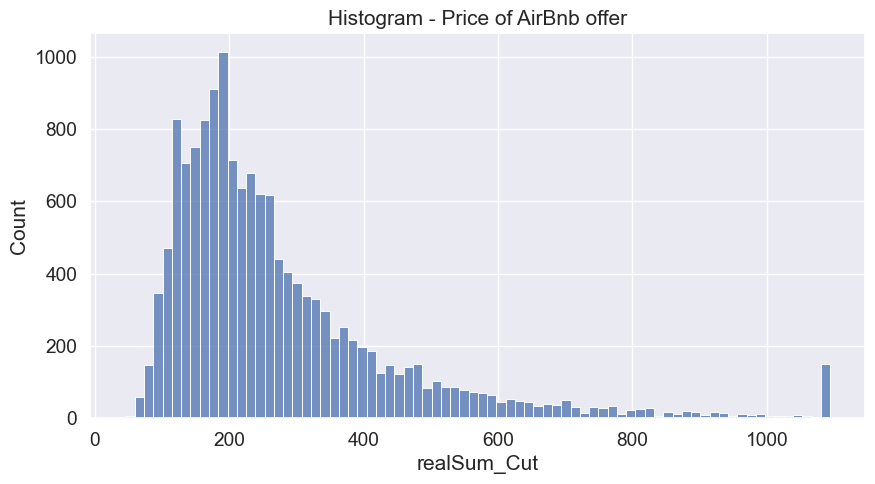

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train.realSum_Cut).set(title="Histogram - Price of AirBnb offer")
plt.show()

#### Discrete variables transformation

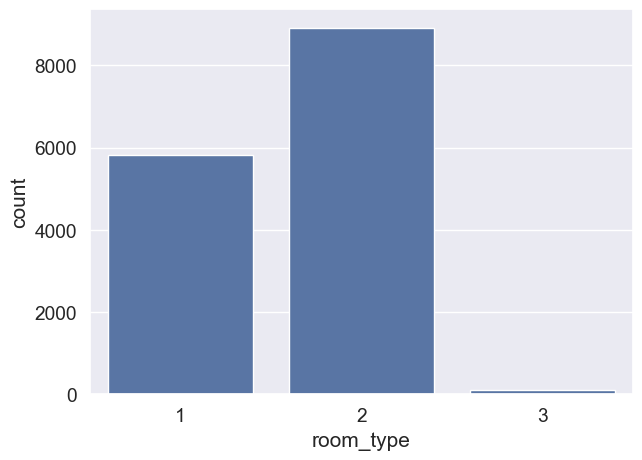

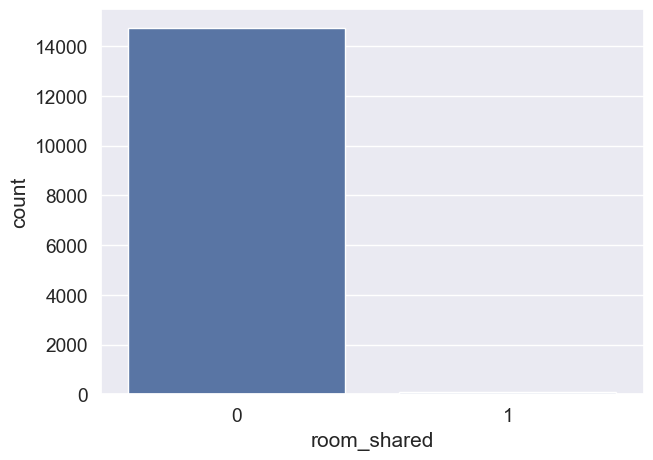

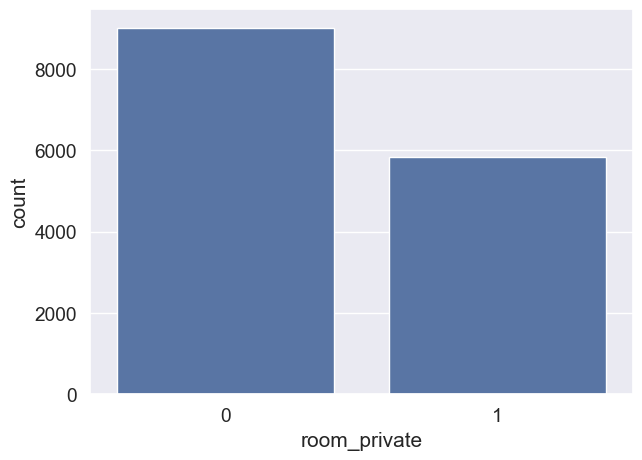

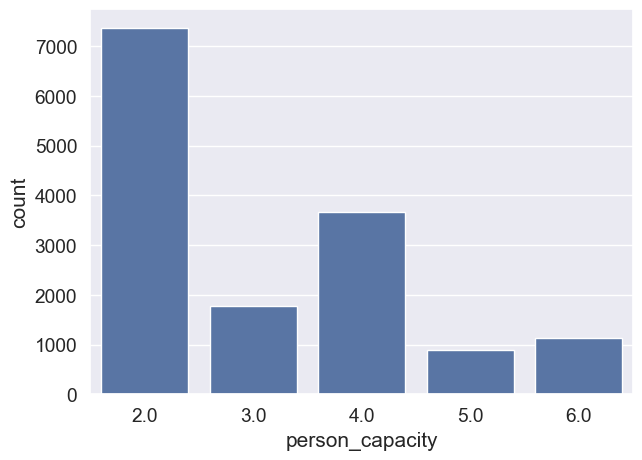

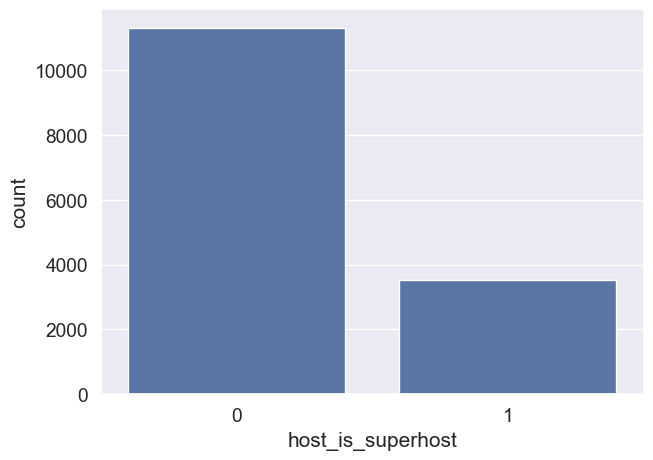

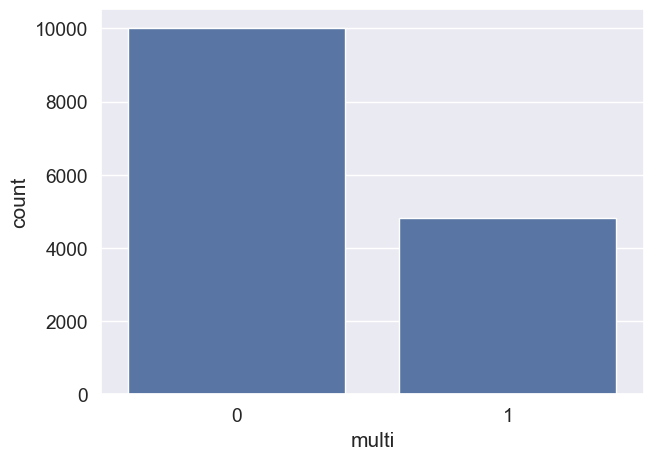

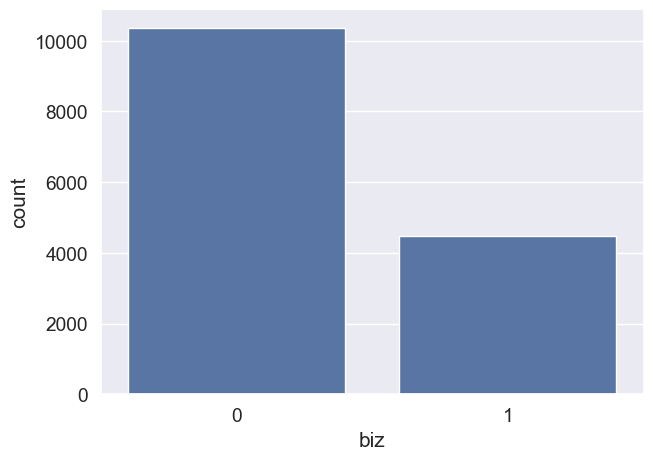

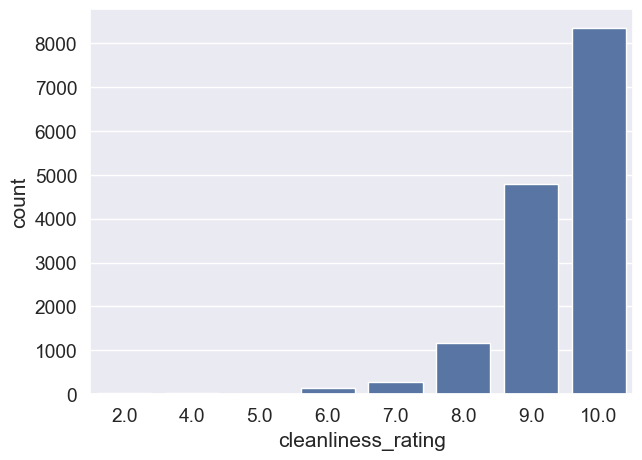

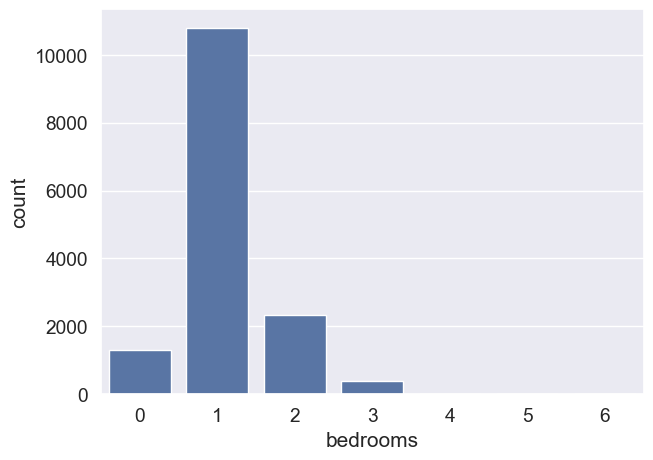

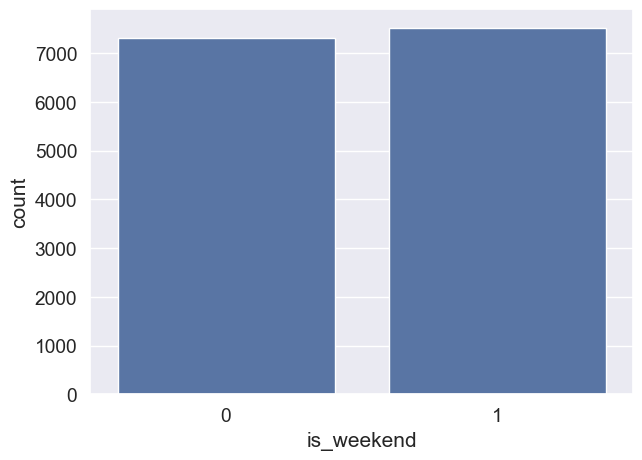

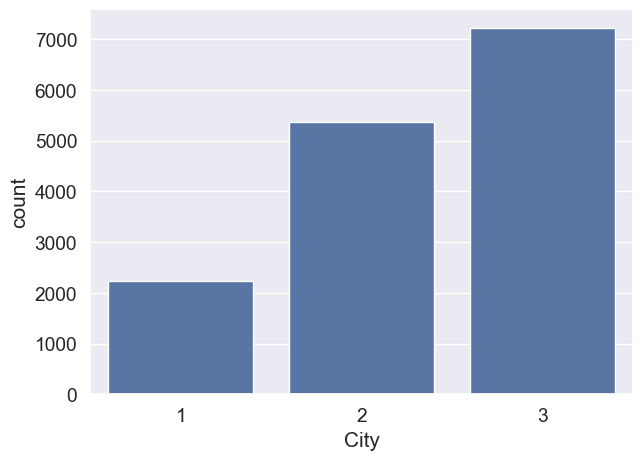

In [16]:
Col= ['room_type', 'room_shared','room_private','person_capacity','host_is_superhost','multi', 'biz', 'cleanliness_rating', 'bedrooms', 'is_weekend', 'City' ]
for col in Col:
    plt.figure(figsize=(7,5))
    sns.countplot(x=col, data=df_train)
    plt.show()

We transform the variables "room_type", "cleanliness_rating", and "bedrooms" by clipping the range.

In [17]:
df_train.bedrooms.describe()

count    14838.000000
mean         1.126432
std          0.591030
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: bedrooms, dtype: float64

We create longitude and latitude bins (3 for each variable) and turn them into categorical variable. We want to measure how particular region can influence the price of the AirBnB.

In [22]:
#lng
_, longitude_bins = pd.qcut(df_train.lng, q=3, retbins=True)
df_train["Longitude_disc"] = pd.cut(df_train.lng, longitude_bins)
df_train = pd.get_dummies(df_train, columns=["Longitude_disc"], drop_first=False)

#lat
_, latitude_bins = pd.qcut(df_train.lat, q=3, retbins=True)
df_train["Latitude_disc"] = pd.cut(df_train.lat, latitude_bins)
df_train = pd.get_dummies(df_train, columns=["Latitude_disc"], drop_first=False)

After all the transformation the dataset looks as follows:

In [23]:
df_train = pd.read_csv("data/output/data_train.csv")
df_test = pd.read_csv("data/output/data_test.csv")

In [152]:
df_train

room_type  room_private  person_capacity  host_is_superhost  multi  \
0              2             0              4.0                  0      0   
1              1             1              5.0                  0      0   
2              2             0              5.0                  0      0   
3              2             0              4.0                  0      1   
4              2             0              6.0                  0      0   
...          ...           ...              ...                ...    ...   
14833          1             1              4.0                  0      0   
14834          1             1              2.0                  1      1   
14835          1             1              2.0                  1      0   
14836          1             1              3.0                  1      1   
14837          2             0              2.0                  0      0   

       biz  cleanliness_rating  guest_satisfaction_overall  bedrooms  \
0        0                10.0                       100.0         2   
1        0                 8.0                        92.0         2   
2        0                 9.0                       100.0         2   
3        0                 9.0                       100.0         1   
4        1                10.0                        98.0         3   
...    ...                 ...                         ...       ...   
14833    1                 9.0                        90.0         1   
14834    0                10.0                       100.0         1   
14835    1                10.0                        97.0         1   
14836    0                10.0                        97.0         1   
14837    1                10.0                        94.0         1   

           dist  metro_dist       lng       lat  is_weekend  city  \
0      3.502522    0.454217  12.53763  41.88369           0     3   
1      0.515832    0.127760   2.35624  48.85254           0     2   
2      2.361842    0.828980  12.50400  41.87965           0     3   
3      1.692157    0.290232   2.37554  48.85891           0     2   
4      1.345889    0.199507  12.48700  41.90500           1     3   
...         ...         ...       ...       ...         ...   ...   
14833  5.159208    0.349342  12.44009  41.90012           0     3   
14834  2.929209    0.345383   2.33305  48.87949           1     2   
14835  1.447936    0.312248  12.50500  41.88800           1     3   
14836  2.134528    0.478199  12.50695  41.88198           1     3   
14837  1.988358    0.924941  12.48075  41.89297           1     3   

       realsum_cut  longitude_disc_2_093_2_347  longitude_disc_2_347_12_47  \
0       126.715454                       False                       False   
1       730.030760                       False                        True   
2       172.772540                       False                       False   
3       671.078370                       False                        True   
4       373.366360                       False                       False   
...            ...                         ...                         ...   
14833   118.766510                       False                        True   
14834   207.148850                        True                       False   
14835   158.978790                       False                       False   
14836   113.155495                       False                       False   
14837   230.519260                       False                       False   

       longitude_disc_12_47_12_583  latitude_disc_41_35_41_893  \
0                             True                        True   
1                            False                       False   
2                             True                        True   
3                            False                       False   
4                             True                       False   
...                            ...                     

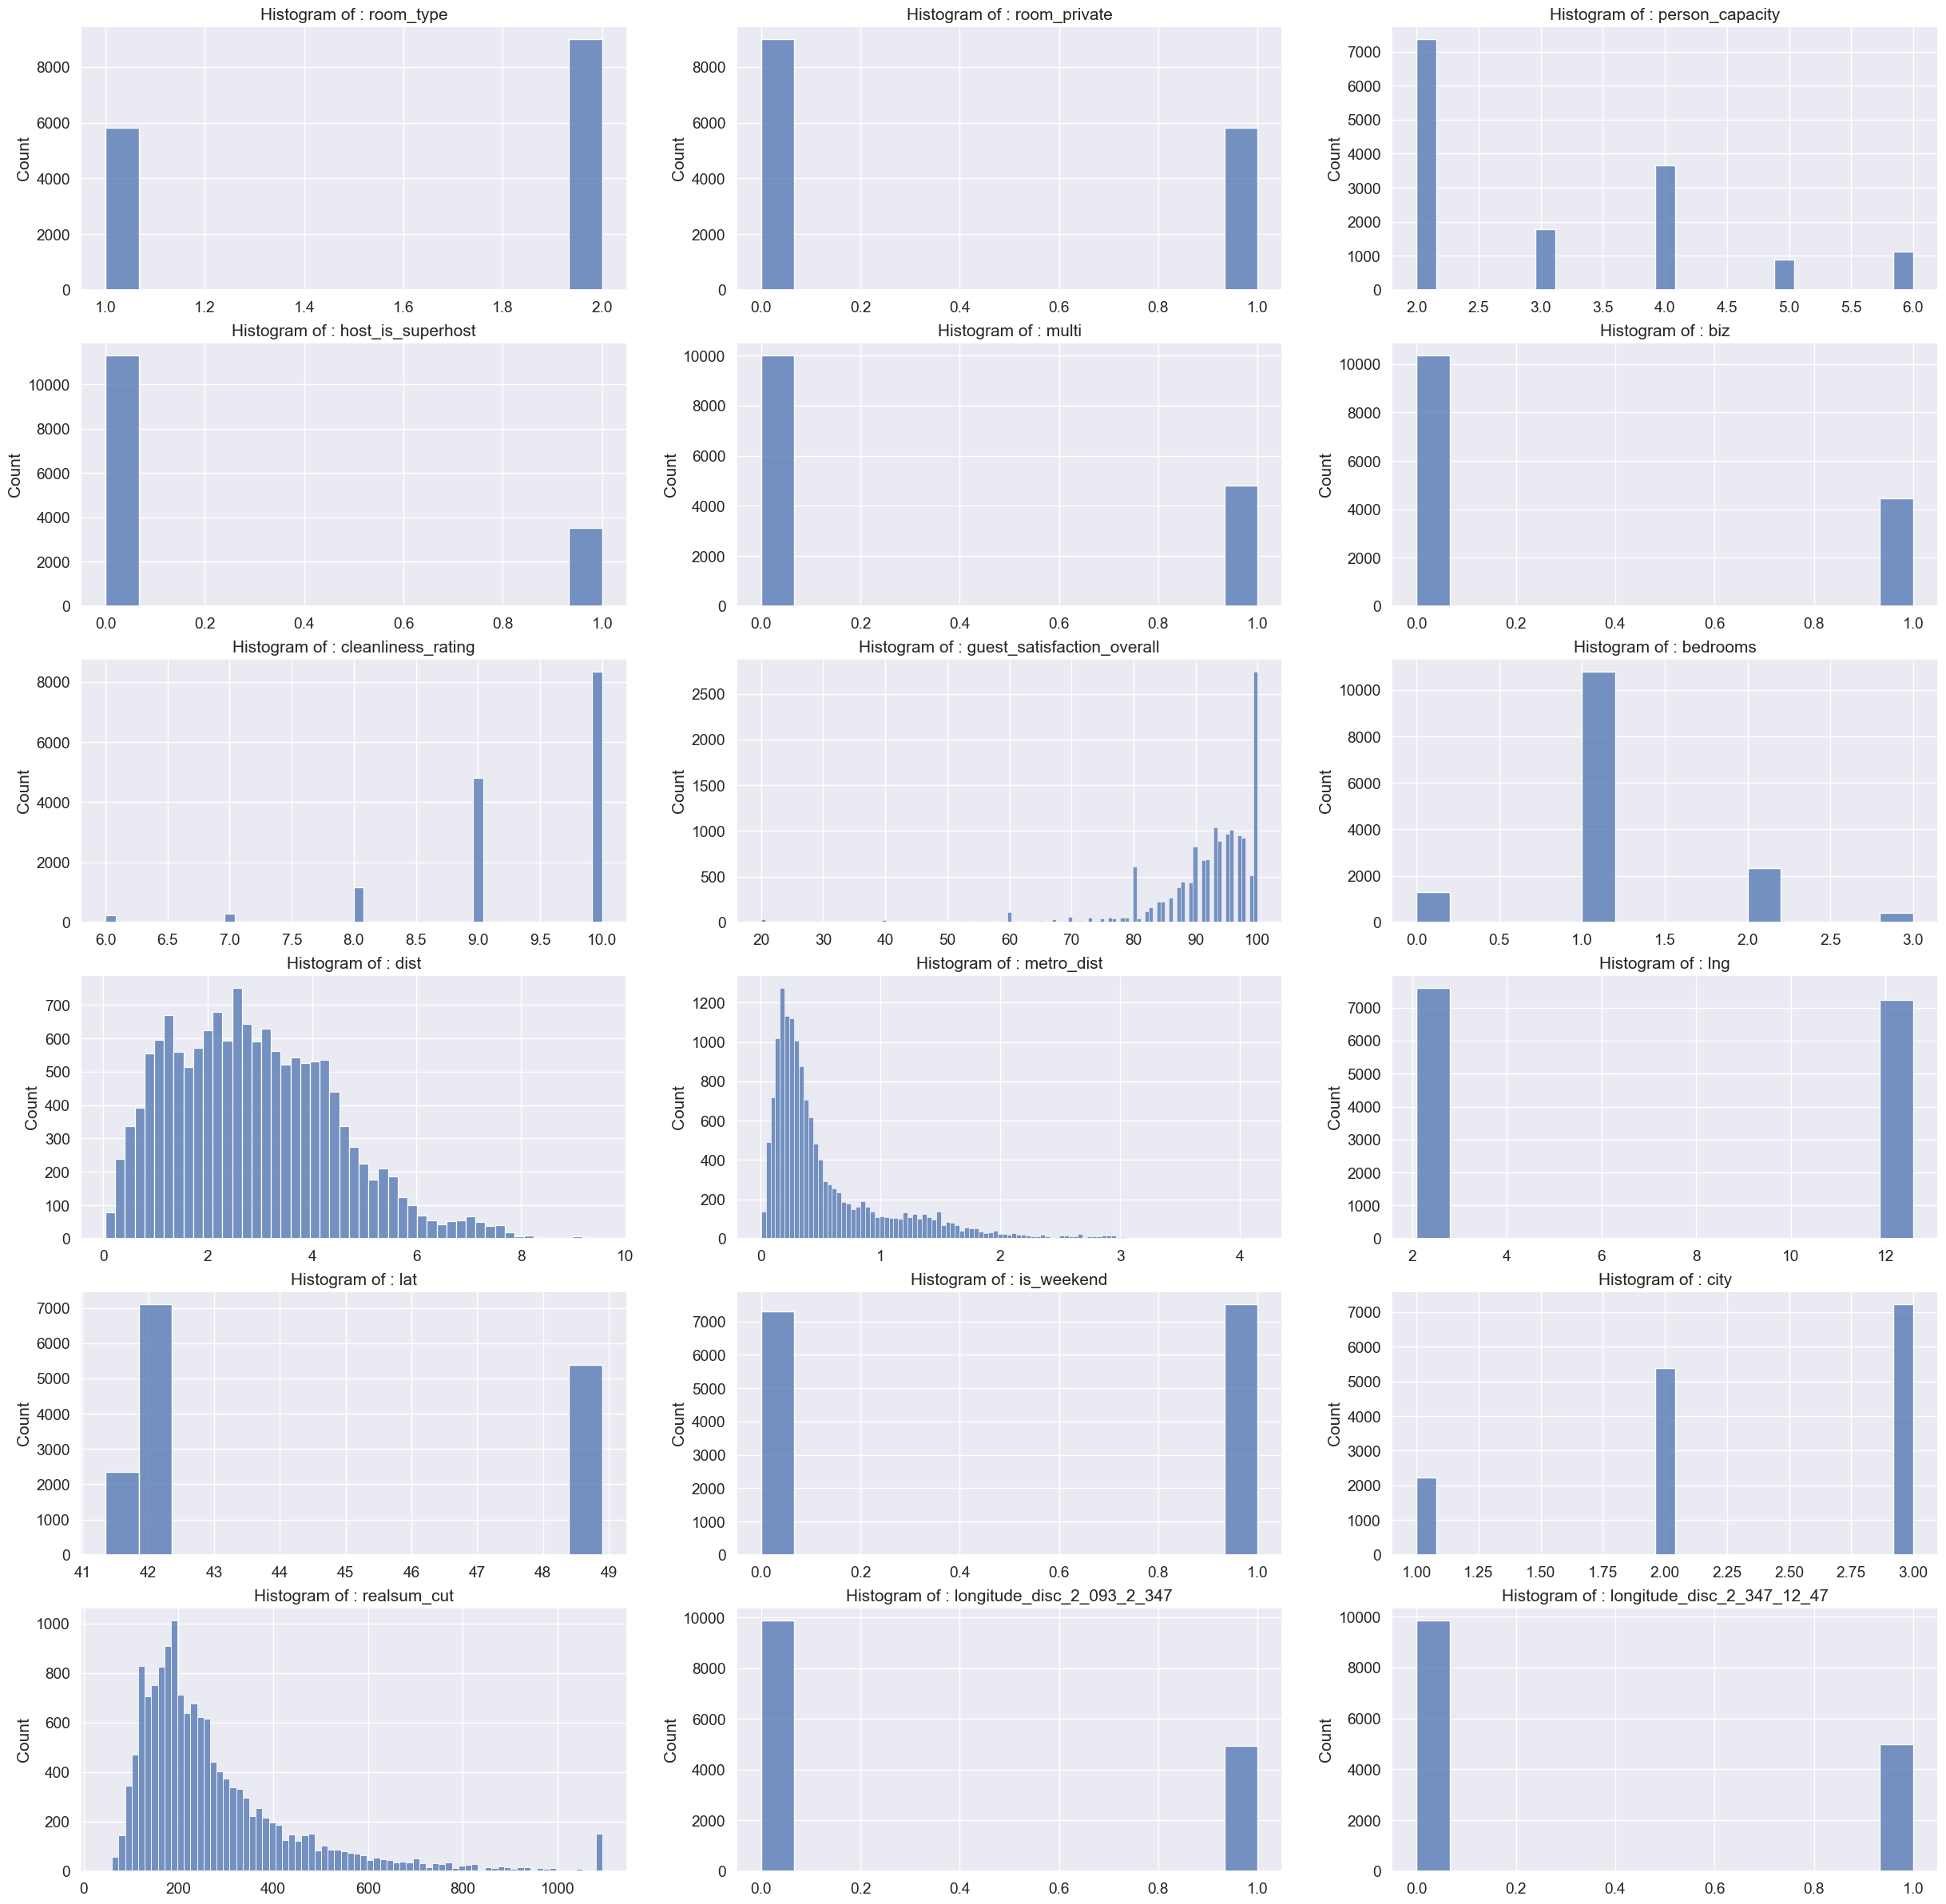

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(30, 30))
for i, ax in zip(df_train.columns, axes.flat):
    sns.histplot(x=df_train[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

### Feature Selection

In [26]:
x_col = ['room_type', 'room_private', 'person_capacity', 'host_is_superhost',
       'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist',
       'lng', 'lat', 'is_weekend', 'city',
       'longitude_disc_2_093_2_347', 'longitude_disc_2_347_12_47',
       'longitude_disc_12_47_12_583', 'latitude_disc_41_35_41_893',
       'latitude_disc_41_893_48_837', 'latitude_disc_48_837_48_901']
y_col = 'realsum_cut'

In [27]:
general_ranking = pd.DataFrame(index=x_col)

We defined function for feature selection based on mutual information, f-score, and correlation.

In [28]:
def feature_selection(df_train, y_col):
    x_col = df_train.columns.tolist()
    x_col.remove(y_col)
    mi = dict()
    fscore = dict()
    corr = list()
    for i in x_col:
        mi.update({i: mutual_info_regression(df_train[[i]].values, df_train[y_col].values)[0]})
        fscore.update({i: f_regression(df_train[[i]].values, df_train[y_col].values)[1]})
        corr.append(stats.spearmanr(df_train.loc[:, y_col].values, df_train.loc[:, i].values)[0])

    miDF = pd.DataFrame.from_dict(mi, orient="index", columns=["mi_score"])
    fscoreDF = pd.DataFrame.from_dict(fscore, orient="index", columns=["f_score"])
    fscoreDF["sign"] = np.where(fscoreDF.f_score < 0.05, 1, 0)
    corrDF = pd.DataFrame(corr, index=x_col, columns=["corr"])

    general_ranking = pd.DataFrame(index=x_col)
    general_ranking = general_ranking.join(miDF)
    general_ranking = general_ranking.join(fscoreDF)
    general_ranking = general_ranking.join(corrDF)

    return general_ranking

We create the Elastic Net model to check the coefficients of the variables.

Text(0.5, 1.0, 'Coefficients in the Elastic Net Model')

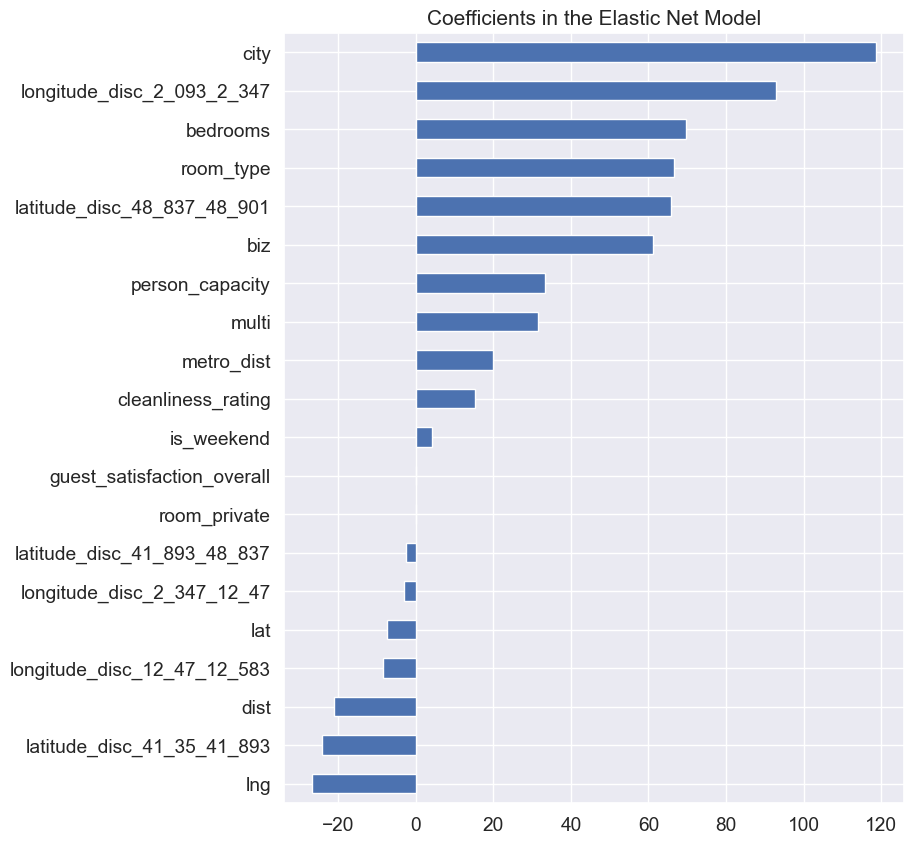

In [29]:
en_res = pd.DataFrame(index=x_col)

def rmse_cv(model, df_train, x_col, y_col):
    rmse = np.sqrt(
        -cross_val_score(
            model,
            df_train.loc[:, x_col],
            df_train.loc[:, y_col],
            scoring="neg_mean_squared_error",
            cv=5,
        )
    )
    return rmse

alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
l1_ratios = [1, 0.9, 0.8, 0.7, 0.5, 0.4, 0.3]

cv_elastic = [
    rmse_cv(ElasticNet(alpha=alpha, l1_ratio=l1_ratio), df_train, x_col, y_col).mean()
    for (alpha, l1_ratio) in product(alphas, l1_ratios)
]

elastic = ElasticNet(alpha=0.0005, l1_ratio=1)
elastic.fit(df_train.loc[:, x_col], df_train.loc[:, y_col])

coef = pd.Series(elastic.coef_, index=df_train.loc[:, x_col].columns)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

plt.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Elastic Net Model")

In [30]:
fr = pd.read_csv("data/output/general_ranking.csv")

Final ranking of the variables based on the various metrics is as follows:

In [31]:
fr

Unnamed: 0  mi_score    sign_fscore  sign_fscore_0_1  \
0                     room_type  0.331133   0.000000e+00                1   
1                  room_private  0.329104   0.000000e+00                1   
2               person_capacity  0.330491   0.000000e+00                1   
3             host_is_superhost  0.148924   1.191357e-11                1   
4                         multi  0.141778   5.449580e-47                1   
5                           biz  0.175463   6.055661e-42                1   
6            cleanliness_rating  0.185011   4.199777e-01                0   
7    guest_satisfaction_overall  0.279597   2.497691e-01                0   
8                      bedrooms  0.257232  2.416789e-276                1   
9                          dist  0.368394   4.422992e-81                1   
10                   metro_dist  0.364663  4.990226e-163                1   
11                          lng  0.859389   0.000000e+00                1   
12                          lat  0.814053   0.000000e+00                1   
13                   is_weekend  0.198715   1.996725e-01                0   
14                         city  0.730737  9.967065e-273                1   
15   longitude_disc_2_093_2_347  0.381556  1.495659e-284                1   
16   longitude_disc_2_347_12_47  0.191824   7.234935e-02                0   
17  longitude_disc_12_47_12_583  0.318238  7.138454e-256                1   
18   latitude_disc_41_35_41_893  0.308283  1.486364e-175                1   
19  latitude_disc_41_893_48_837  0.266758  3.950973e-124                1   
20  latitude_disc_48_837_48_901  0.437252   0.000000e+00                1   

        corr     EN_coef  boruta_rank  
0   0.460737   66.605290            1  
1  -0.460737   -0.013505            1  
2   0.347027   33.363330            1  
3  -0.052432         NaN            6  
4  -0.156543   31.634403            9  
5   0.090391   61.137344            1  
6  -0.008274   15.145918            1  
7   0.058202    0.100369            1  
8   0.189562   69.666650            1  
9  -0.187185  -21.108894            1  
10 -0.290896   19.963486            1  
11 -0.391676  -26.697237            1  
12  0.376978   -7.342648            1  
13  0.024887    4.033917            1  
14 -0.364870  118.697960            2  
15  0.295820   92.785460            4  
16  0.010469   -3.129059            7  
17 -0.306546   -8.543576           10  
18 -0.306700  -24.304527            5  
19 -0.172788   -2.632091            3  
20  0.479799   65.790436            7

## Model trained for each city
### Data Preparation
We transform the data in the similar way as for the global model.

In [33]:
df_barcelona_train, df_barcelona_test = train_test_split(df_barcelona, test_size=0.2, random_state=123)
df_paris_train, df_paris_test = train_test_split(df_paris, test_size=0.2, random_state=123)
df_rome_train, df_rome_test = train_test_split(df_rome, test_size=0.2, random_state=123)

In [36]:
#Change of boolean variables into integers
df_barcelona_train["is_weekend"]= df_barcelona_train["is_weekend"].astype(int)
df_barcelona_train["room_shared"]= df_barcelona_train["room_shared"].astype(int)
df_barcelona_train["room_private"]= df_barcelona_train["room_private"].astype(int)
df_barcelona_train["host_is_superhost"]= df_barcelona_train["host_is_superhost"].astype(int)

#Change of object variables into categorical
df_barcelona_train['room_type'] = df_barcelona_train['room_type'].map({'Private room': 1,'Entire home/apt':2}).fillna(3)
df_barcelona_train["room_type"]= df_barcelona_train["room_type"].astype(int)
df_barcelona_train.room_type.isna().sum()

#Dropping out initial indices as we have standardized forms
df_barcelona_train=df_barcelona_train.drop(columns=["attr_index", 'attr_index_norm'])
df_barcelona_train=df_barcelona_train.drop(columns=["rest_index", 'rest_index_norm'])

df_paris_train["is_weekend"]= df_paris_train["is_weekend"].astype(int)
df_paris_train["room_shared"]= df_paris_train["room_shared"].astype(int)
df_paris_train["room_private"]= df_paris_train["room_private"].astype(int)
df_paris_train["host_is_superhost"]= df_paris_train["host_is_superhost"].astype(int)

df_paris_train['room_type'] = df_paris_train['room_type'].map({'Private room': 1,'Entire home/apt':2}).fillna(3)
df_paris_train["room_type"]= df_paris_train["room_type"].astype(int)
df_paris_train.room_type.isna().sum()

df_paris_train=df_paris_train.drop(columns=["attr_index", 'attr_index_norm'])
df_paris_train=df_paris_train.drop(columns=["rest_index", 'rest_index_norm'])

df_rome_train["is_weekend"]= df_rome_train["is_weekend"].astype(int)
df_rome_train["room_shared"]= df_rome_train["room_shared"].astype(int)
df_rome_train["room_private"]= df_rome_train["room_private"].astype(int)
df_rome_train["host_is_superhost"]= df_rome_train["host_is_superhost"].astype(int)

df_rome_train['room_type'] = df_rome_train['room_type'].map({'Private room': 1,'Entire home/apt':2}).fillna(3)
df_rome_train["room_type"]= df_rome_train["room_type"].astype(int)
df_rome_train.room_type.isna().sum()

df_rome_train=df_rome_train.drop(columns=["attr_index", 'attr_index_norm'])
df_rome_train=df_rome_train.drop(columns=["rest_index", 'rest_index_norm'])

Let's check the histograms of the variables in the datasets of each city.

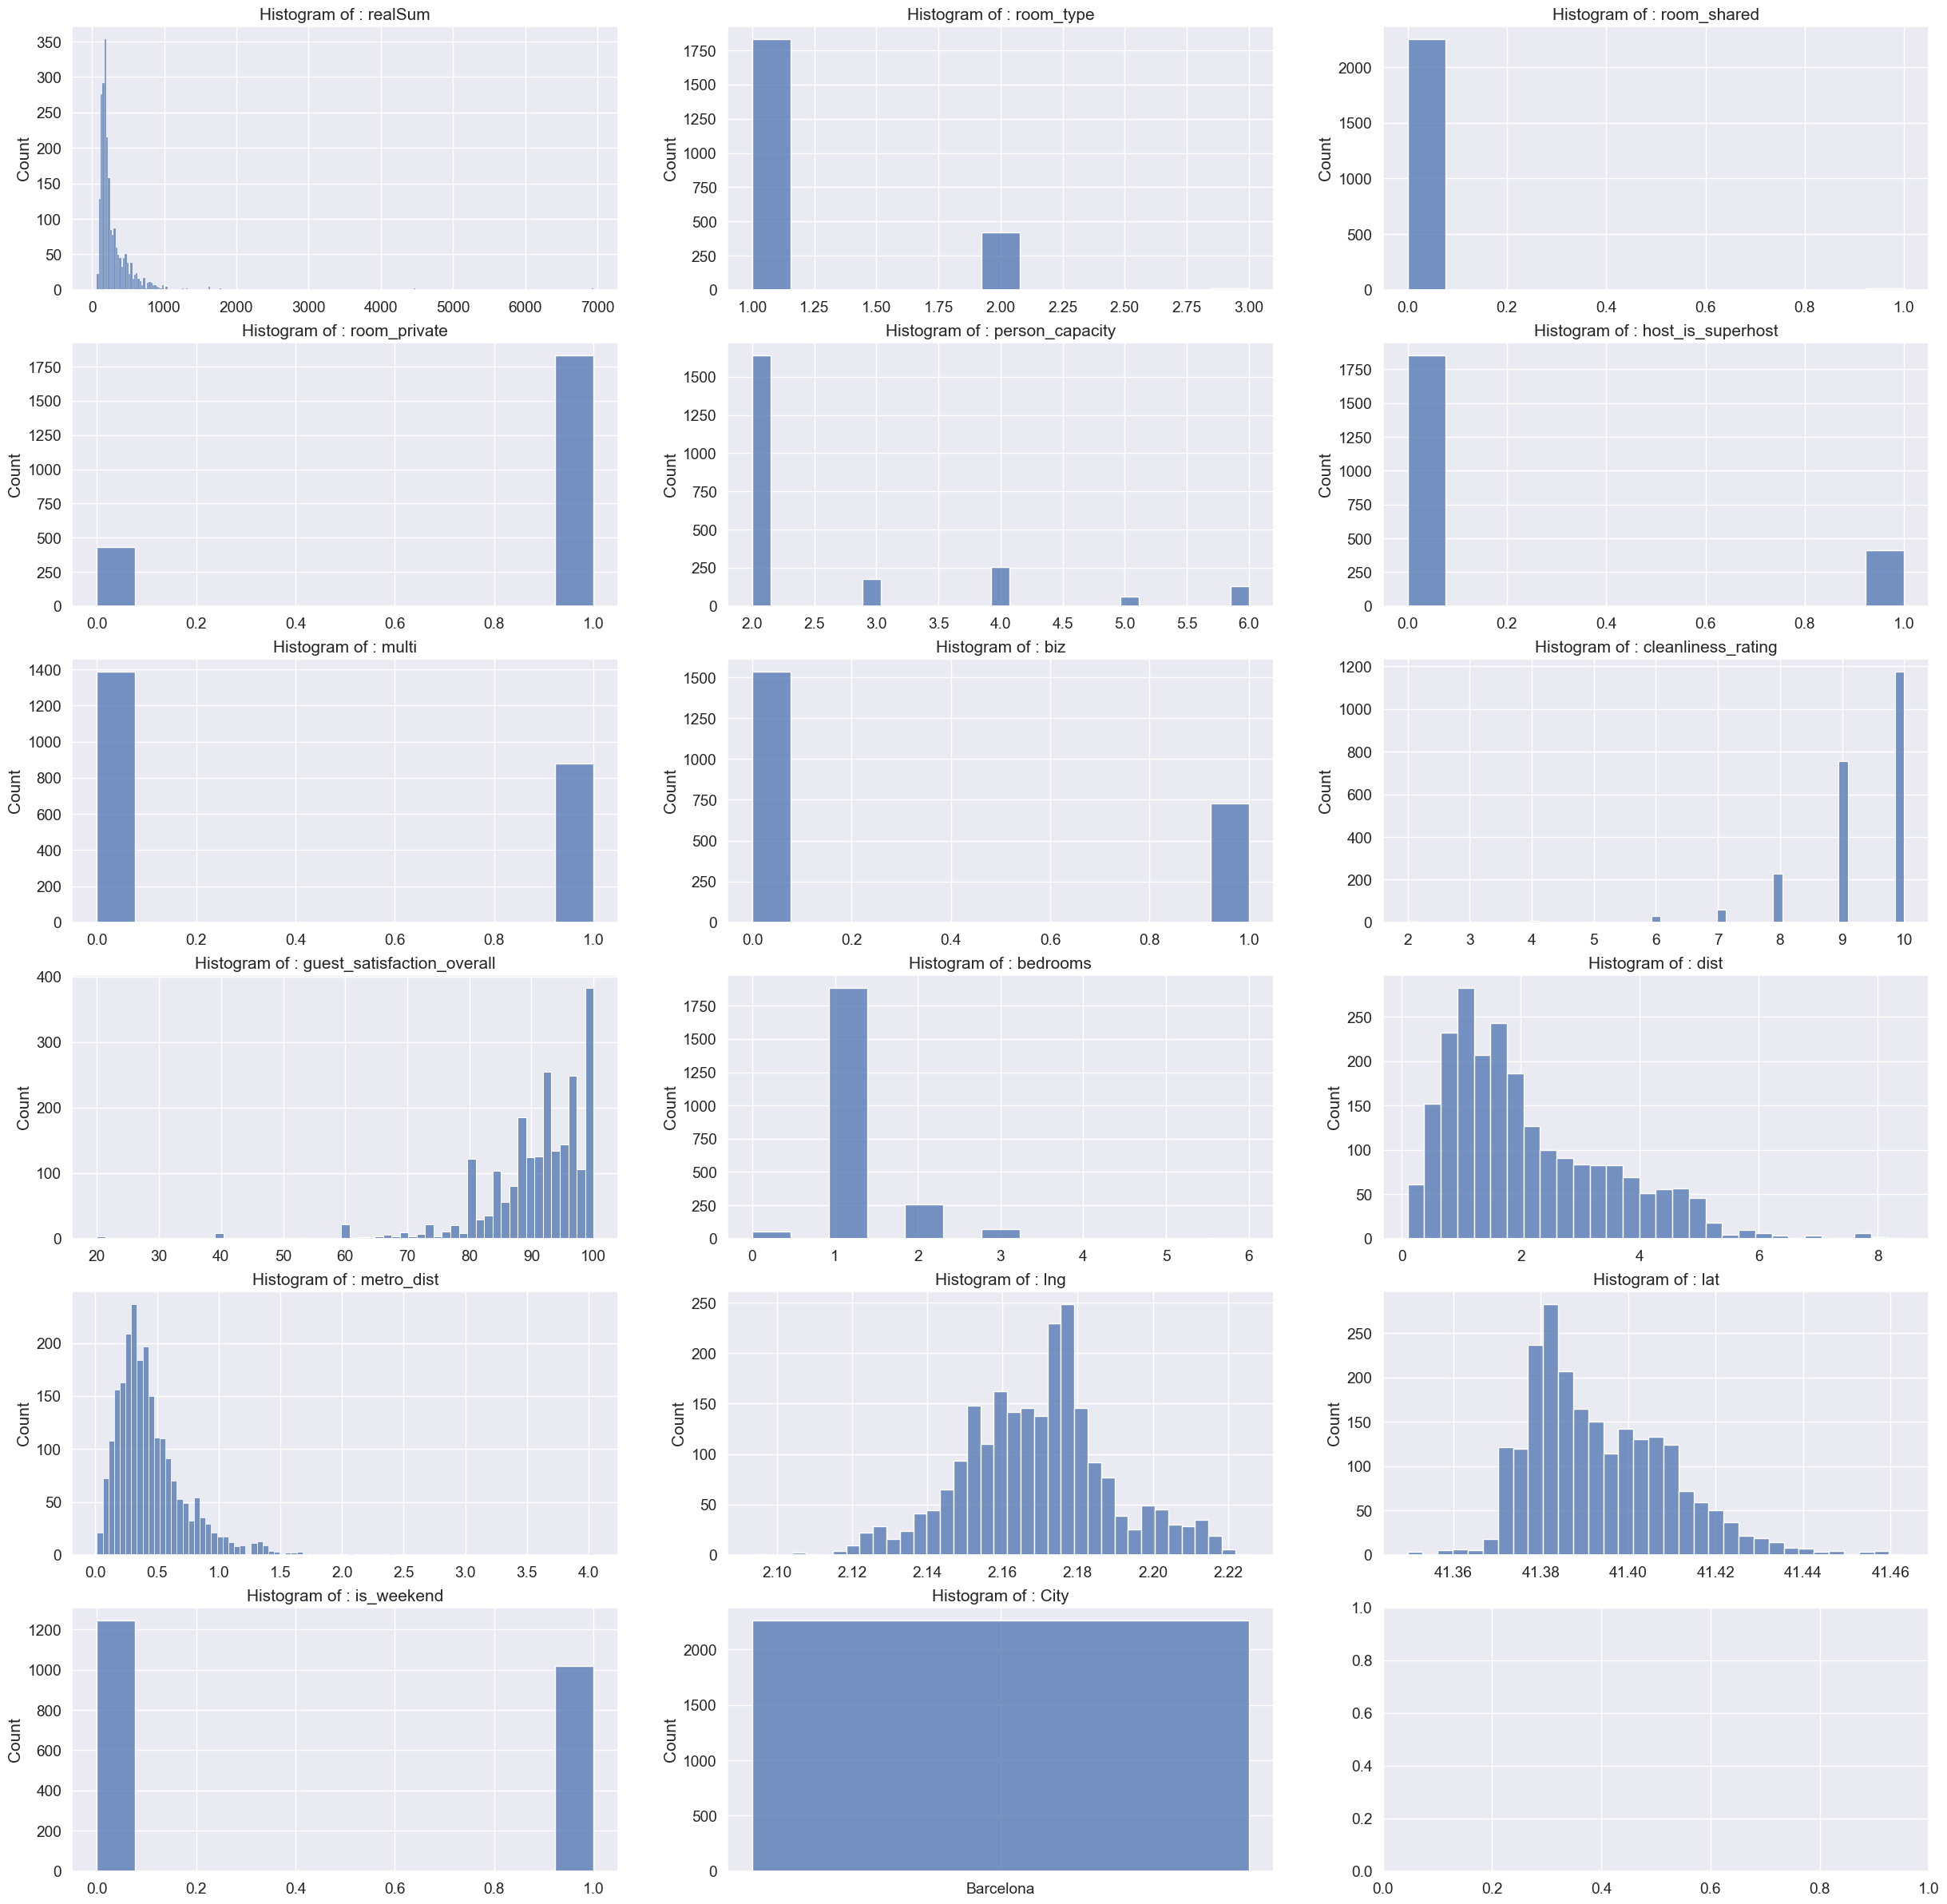

In [37]:
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(30, 30))
for i, ax in zip(df_barcelona_train.columns, axes.flat):
    sns.histplot(x=df_barcelona_train[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

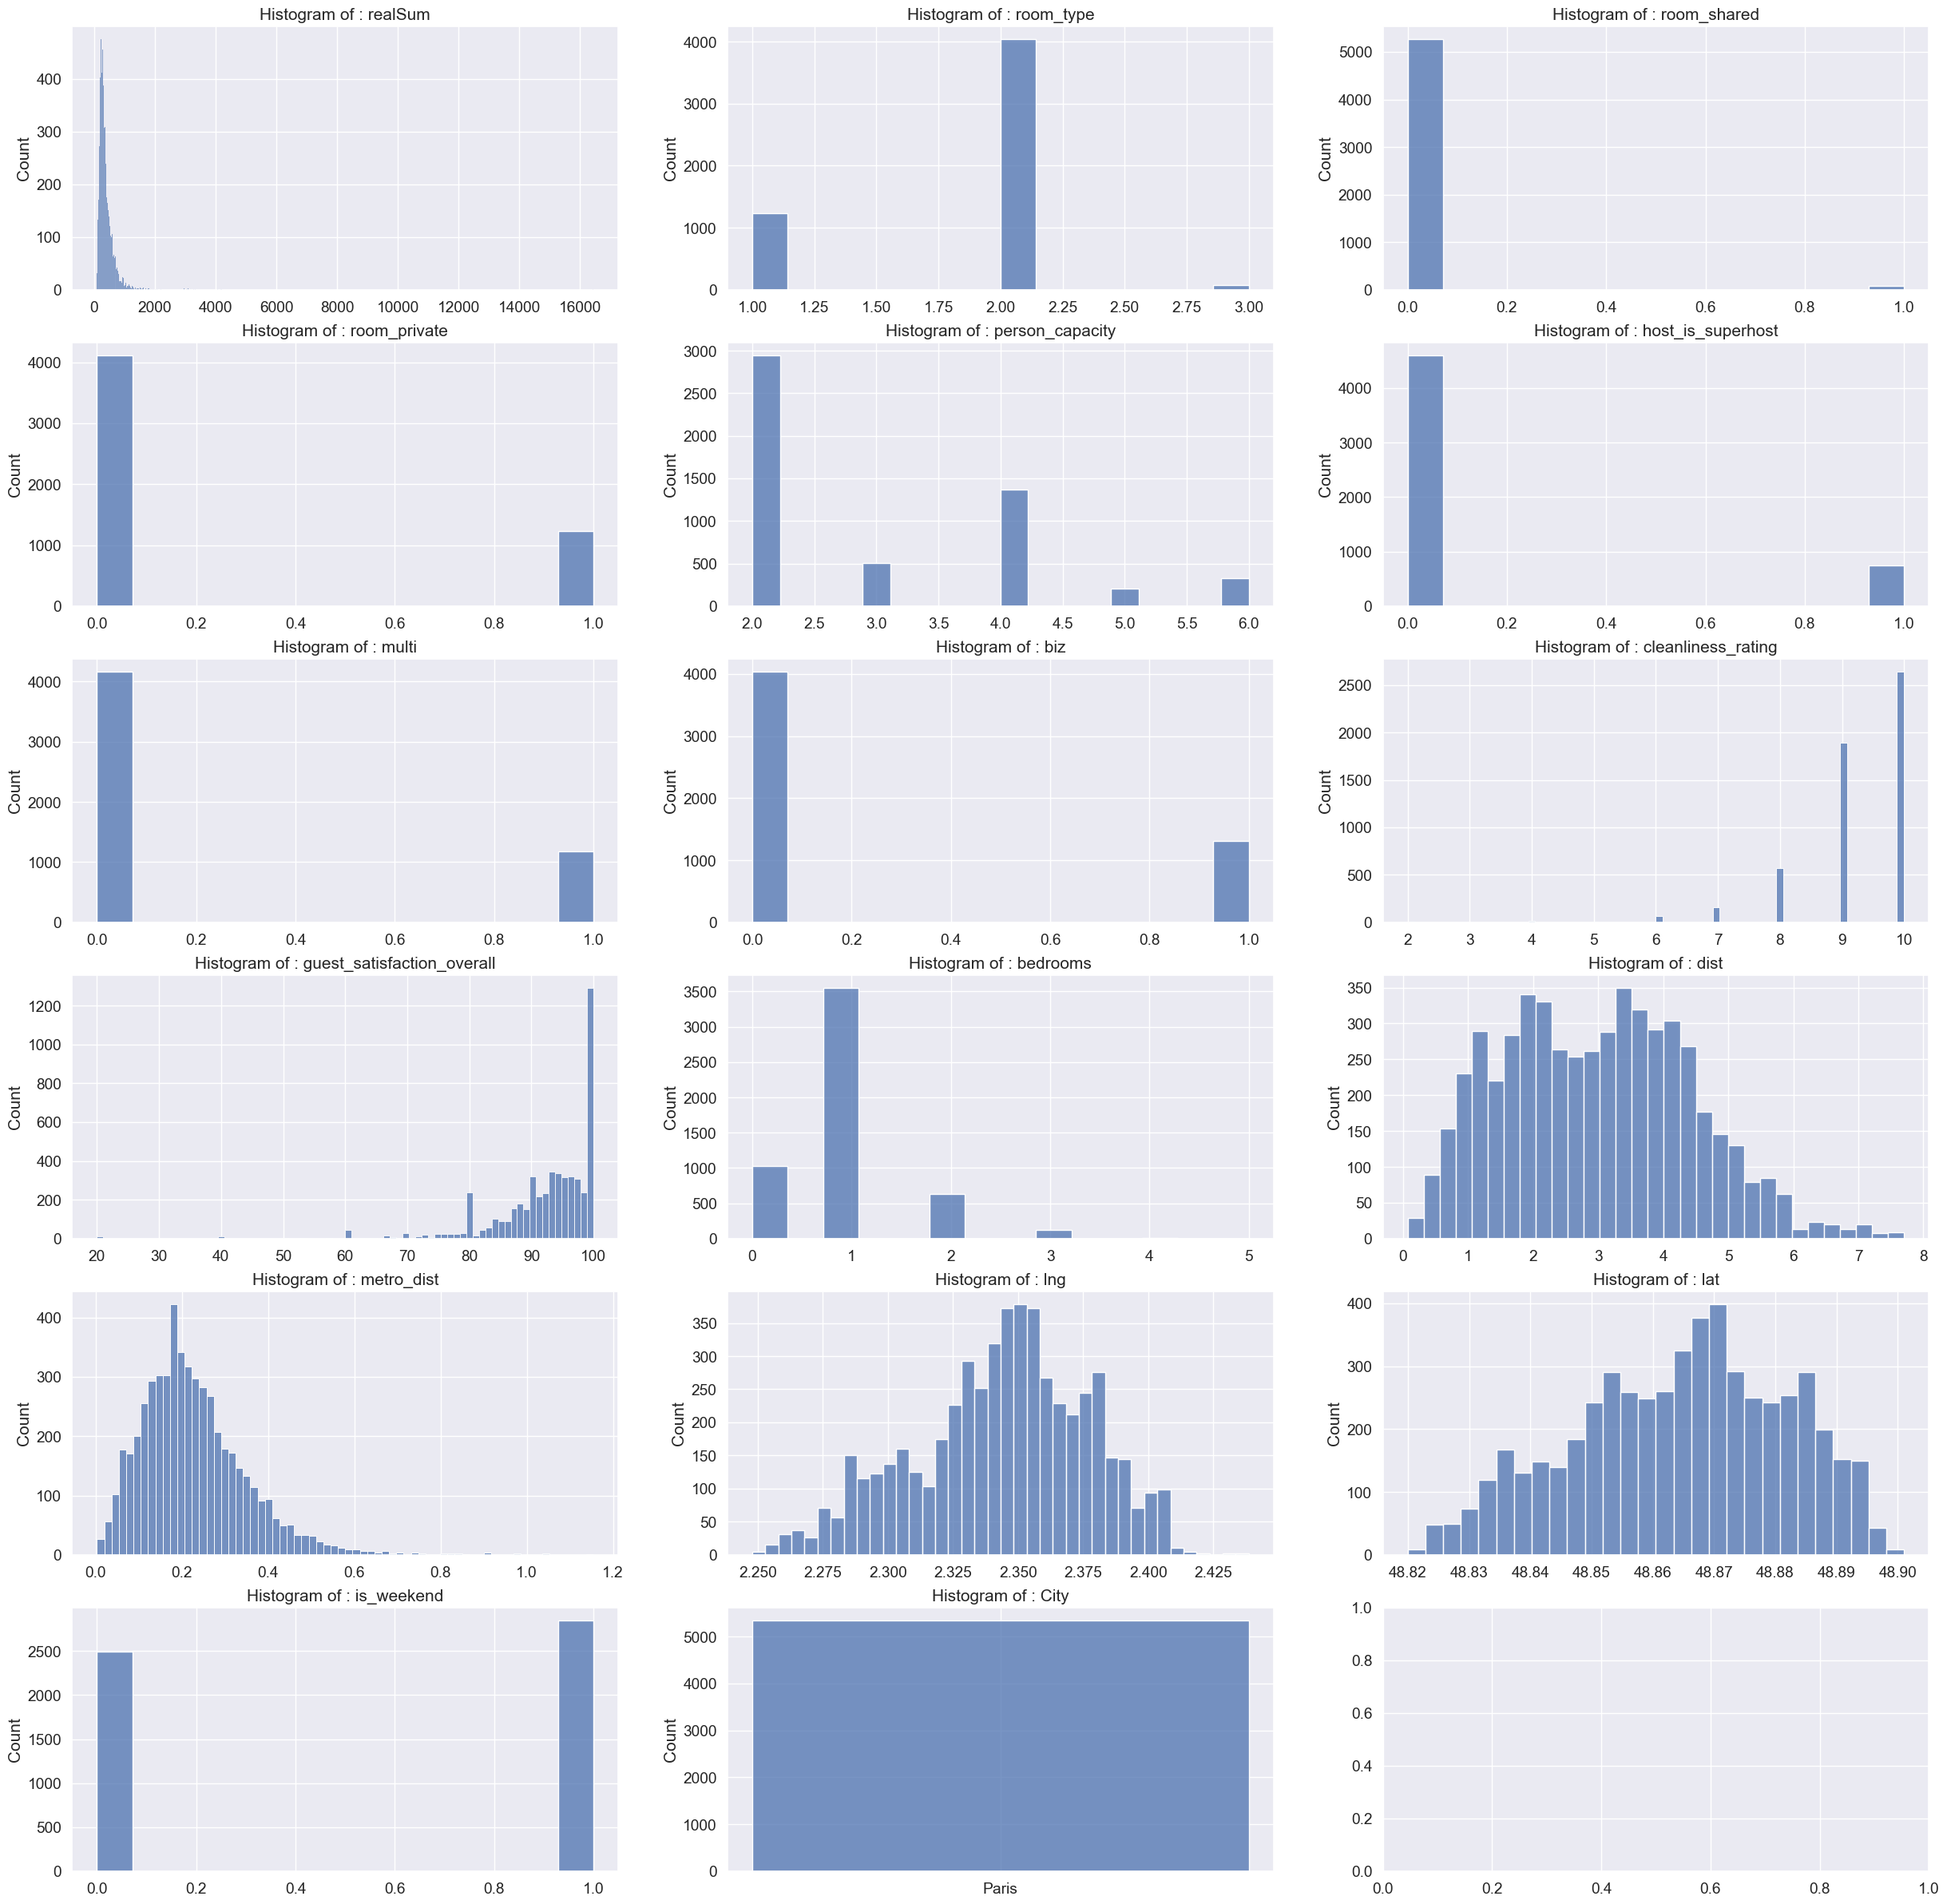

In [39]:
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(30, 30))
for i, ax in zip(df_paris_train.columns, axes.flat):
    sns.histplot(x=df_paris_train[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

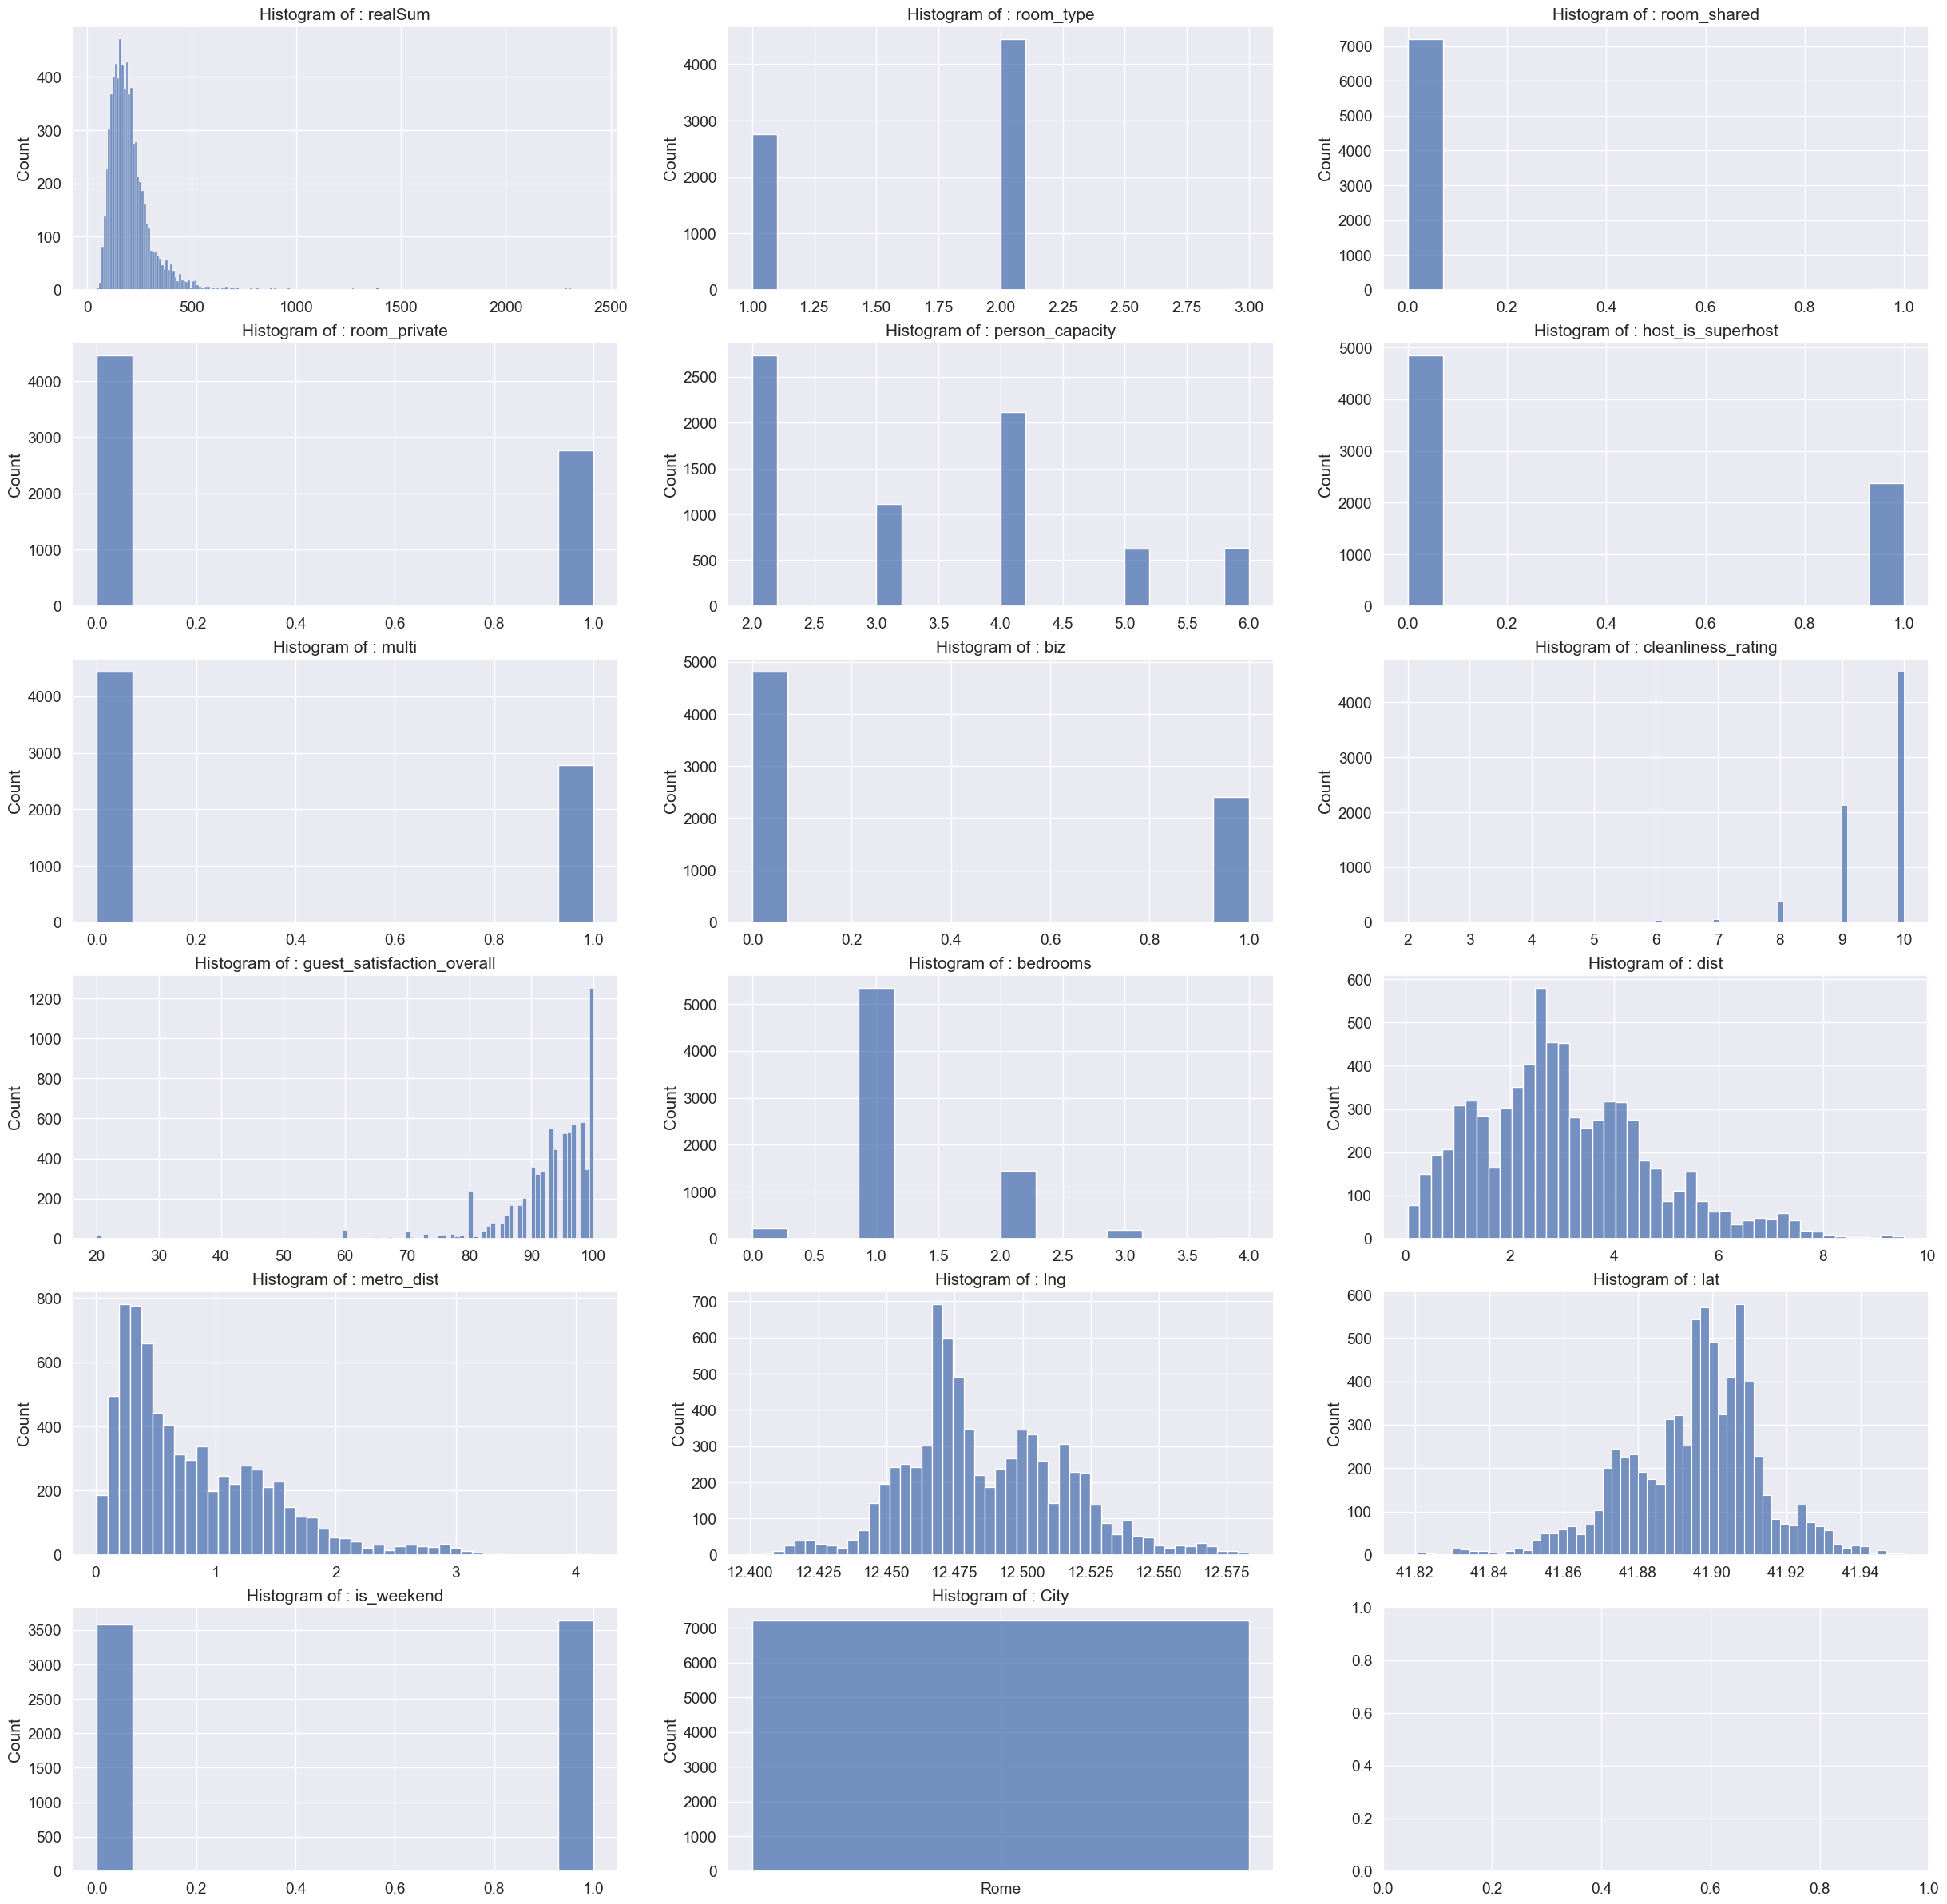

In [40]:
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(30, 30))
for i, ax in zip(df_rome_train.columns, axes.flat):
    sns.histplot(x=df_rome_train[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

In [41]:
df_barcelona_train = pd.read_csv("data/output/data_barcelona_train.csv")
df_paris_train = pd.read_csv("data/output/data_paris_train.csv")
df_rome_train = pd.read_csv("data/output/data_rome_train.csv")

After histogram analysis, we conclude that the smaller dataset needs similar feature engineering as the global model.

In [43]:
df_barcelona_train

room_type  room_private  person_capacity  host_is_superhost  multi  biz  \
0             1             1              2.0                  0      1    0   
1             1             1              2.0                  0      0    1   
2             2             0              3.0                  0      0    1   
3             1             1              2.0                  0      0    0   
4             1             1              2.0                  0      1    0   
...         ...           ...              ...                ...    ...  ...   
2261          1             1              4.0                  0      1    0   
2262          1             1              2.0                  0      0    1   
2263          1             1              2.0                  0      0    0   
2264          1             1              3.0                  1      1    0   
2265          1             1              2.0                  0      0    0   

      cleanliness_rating  guest_satisfaction_overall  bedrooms      dist  \
0                    9.0                        89.0         1  1.243404   
1                   10.0                       100.0         1  6.060370   
2                   10.0                        95.0         1  1.280993   
3                   10.0                        93.0         1  2.090314   
4                    8.0                        74.0         1  2.934882   
...                  ...                         ...       ...       ...   
2261                10.0                        80.0         2  3.237347   
2262                10.0                        92.0         1  1.478423   
2263                 9.0                        93.0         1  1.241717   
2264                10.0                       100.0         1  5.795137   
2265                 9.0                        90.0         1  5.001333   

      metro_dist      lng       lat  is_weekend  realsum_cut  \
0       0.523179  2.18075  41.37939           1   213.885070   
1       0.790421  2.18137  41.44105           1   130.565320   
2       0.729701  2.17525  41.39798           0   485.954350   
3       0.127860  2.17517  41.40556           0   115.670166   
4       0.359177  2.13996  41.37348           1   138.943850   
...          ...      ...       ...         ...          ...   
2261    0.084802  2.14017  41.40572           0   543.905760   
2262    0.187383  2.15233  41.38710           1   196.895300   
2263    0.158210  2.16796  41.37606           1   150.580670   
2264    2.056840  2.11655  41.42037           0   318.151150   
2265    0.826473  2.20569  41.42330           0   127.539740   

      longitude_disc_2_093_2_161  longitude_disc_2_161_2_177  \
0                          False                       False   
1                          False                       False   
2                          False                        True   
3                          False                        True   
4                           True                       False   
...                          ...                         ...   
2261                        True                       False   
2262                        True                       False   
2263                       False                        True   
2264                        True                       False   
2265                       False                       False   

      longitude_disc_2_177_2_226  latitude_disc_2_093_2_161  \
0                           True                      False   
1                           True                      False   
2                          False                      False   
3                          False                      False   
4                          False                       True   
...                          ...                        ...   
2261                       False                       True   
2262                       False                       True   
2263           

In [46]:
import plotly.express as px

In [48]:
fig = px.density_mapbox(df_barcelona_train, lat="lat", lon="lng", z="realsum_cut",
                        center = dict(lat= 41.39, lon=2.15), radius = 12, zoom = 12,
                        mapbox_style = 'open-street-map', opacity=0.5, width=1000, height=800, title="Density of AirBnb offers in Barcelona")
fig.show()

In [50]:
fig = px.density_mapbox(df_paris_train, lat="lat", lon="lng", z="realsum_cut",
                        radius=12, zoom=11, mapbox_style='open-street-map', opacity=0.5, width=1000, height=800,
                        title="Density of AirBnb offers in paris")
fig.show()

In [52]:
fig = px.density_mapbox(df_rome_train, lat="lat", lon="lng", z="realsum_cut",
                        radius=12, zoom=12, mapbox_style='open-street-map', opacity=0.5, width=1000, height=800,
                        title="Density of AirBnb offers in rome")
fig.show()

In [53]:
df_barcelona_test = pd.read_csv("data/output/data_barcelona_test.csv")
df_paris_test = pd.read_csv("data/output/data_paris_test.csv")
df_rome_test = pd.read_csv("data/output/data_rome_test.csv")

### Feature Selection
We perform feature selection for each city dataset. As a result we obtain the ranking of the variables based on various metrics.

In [54]:
fr_barcelona = pd.read_csv("data/output/general_ranking_barcelona.csv")
fr_paris = pd.read_csv("data/output/general_ranking_paris.csv")
fr_rome = pd.read_csv("data/output/general_ranking_rome.csv")

In [55]:
fr_barcelona

Unnamed: 0  mi_score        f_score  sign      corr  \
0                    room_type  0.366934  2.087921e-320     1  0.593715   
1                 room_private  0.374643  2.084957e-320     1 -0.593715   
2              person_capacity  0.396742  9.004931e-308     1  0.565800   
3            host_is_superhost  0.180674   2.638642e-01     0  0.053895   
4                        multi  0.218939   1.134335e-25     1 -0.206526   
5                          biz  0.282533   6.067393e-89     1  0.396837   
6           cleanliness_rating  0.202656   3.527230e-01     0  0.116516   
7   guest_satisfaction_overall  0.286422   1.831318e-02     1  0.082851   
8                     bedrooms  0.274902  1.744800e-176     1  0.410021   
9                         dist  0.374187   6.411860e-18     1 -0.289112   
10                  metro_dist  0.250652   8.719334e-03     1 -0.090859   
11                         lng  0.385027   1.326591e-01     0  0.033536   
12                         lat  0.451435   9.512915e-03     1 -0.083004   
13                  is_weekend  0.140700   6.772048e-01     0  0.002394   
14  longitude_disc_2_093_2_161  0.190710   6.965883e-05     1 -0.095555   
15  longitude_disc_2_161_2_177  0.185801   8.737081e-09     1  0.142239   
16  longitude_disc_2_177_2_226  0.172552   8.534613e-02     0 -0.045159   
17   latitude_disc_2_093_2_161  0.168410   6.965883e-05     1 -0.095555   
18   latitude_disc_2_161_2_177  0.197669   8.737081e-09     1  0.142239   
19   latitude_disc_2_177_2_226  0.166235   8.534613e-02     0 -0.045159   

       EN_coef  boruta_rank  
0   176.039300            1  
1    -0.006800            1  
2    51.055100            1  
3    22.136229            2  
4    -0.567030            7  
5    37.729160            3  
6     8.392040            4  
7     0.570122            1  
8    43.658993            1  
9   -18.583822            1  
10   -3.864239            1  
11  407.056030            1  
12   17.253742            1  
13   44.004436            1  
14  -13.907234            8  
15   -2.360851            5  
16  -10.743725           11  
17   -6.819397           10  
18   -7.129308            5  
19   -7.030373            8

## Global Model - Model Selection

To find the best fit model for our dataset, we applied different models and compared their performance.
1. OLS

First we are using Recursive Feature Elimination with Cross-Validation (RFECV) and Sequential Feature Selector (SFS) to find the best features.

In [59]:
features_candidates_rec = df_train.columns.tolist()
features_candidates_rec.remove("realsum_cut")

estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=10)
selector = selector.fit(
    df_train.loc[:, features_candidates_rec].values, df_train.loc[:, "realsum_cut"].values.ravel()
)

features_candidates_rec = df_train.loc[:, features_candidates_rec].iloc[:, selector.support_].columns.tolist()

In [62]:
features_selection_back = df_train.columns.tolist()
features_selection_back.remove("realsum_cut")
model= LinearRegression()

sf = SFS(
    model,
    k_features=(1, 10),
    forward=True,
    floating=False,
    verbose=0,
    scoring="neg_mean_squared_error",
    cv=5,
)

sffit = sf.fit(df_train.loc[:, features_selection_back].values, df_train.loc[:, "realsum_cut"].values.ravel())

features_selection_back = df_train.loc[:, features_selection_back].columns[list(sffit.k_feature_idx_)]

In [63]:
features_selection_back

Index(['room_type', 'person_capacity', 'multi', 'biz', 'cleanliness_rating',
       'bedrooms', 'dist', 'lat', 'longitude_disc_2_093_2_347',
       'latitude_disc_48_837_48_901'],
      dtype='object')

We define the wrapper function for cross-validation.

In [64]:
def CV_wrapper(df_train, feature, model, num_split, random=None, shuff=False, display_res = False):
    train_mape_list = list()
    val_mape_list = list()

    kf = KFold(n_splits=num_split, shuffle=shuff, random_state=random)
    for train_index, val_index in kf.split(df_train.index.values):
        reg = model
        reg.fit(
        X=df_train[feature].iloc[train_index],
        y=df_train[["realsum_cut"]].iloc[train_index],
        )
        pred_train = reg.predict(df_train[feature].iloc[train_index])   .ravel()
        pred_val = reg.predict(df_train[feature].iloc[val_index])       .ravel()
        train_mape = scoring_wrapper(
            df_train[["realsum_cut"]].iloc[train_index], pred_train
            ).get("mape")
        val_mape = scoring_wrapper(df_train[["realsum_cut"]]            .iloc[val_index], pred_val).get("mape")
        train_mape_list.append(train_mape)
        val_mape_list.append(val_mape)

    if display_res == True:
        view = pd.DataFrame([train_mape_list,val_mape_list]).T.rename(columns={0:"cv_train", 1:"cv_val"})
        return view
    else:

        return train_mape_list, val_mape_list

In [70]:
CV_wrapper(df_train, features_candidates_rec, LinearRegression(), 10, 123,shuff=True, display_res=True).mean()

cv_train    0.340050
cv_val      0.340751
dtype: float64

The results are not satisfactory, so we try regularization with Lasso, Ridge, and Elastic Net.

In [71]:
def lasso_model_wrapper(df_train, feature_selection, num_split, random, shuff=True, display_res = False):
    kf = KFold(n_splits=num_split, shuffle=shuff, random_state=random)

# for alpha in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.025]:
    for alpha in np.logspace(-4, 0, 10): #start, stop, num
        train_mape_list = list()
        val_mape_list = list()

        for train_index, val_index in kf.split(df_train.index.values):
            reg = Lasso(alpha=alpha, fit_intercept=True)
            reg.fit(
            X=df_train[feature_selection].iloc[train_index],
            y=df_train[["realsum_cut"]].iloc[train_index],
            )
            pred_train = reg.predict(df_train[feature_selection].iloc[train_index]).ravel()
            pred_val = reg.predict(df_train[feature_selection].iloc[val_index]).ravel()
            train_mape = scoring_wrapper(
                df_train[["realsum_cut"]].iloc[train_index], pred_train
            ).get("mape")
            val_mape = scoring_wrapper(
                df_train[["realsum_cut"]].iloc[val_index], pred_val
            ).get("mape")
            train_mape_list.append(train_mape)
            val_mape_list.append(val_mape)

    if display_res == True:
        view = pd.DataFrame([train_mape_list, val_mape_list]).T.rename(columns={0: "cv_train", 1: "cv_val"})
        return view
    else:
        return train_mape_list, val_mape_list

In [73]:
lasso_model_wrapper(df_train, features_candidates_rec, 10, 123, shuff=True, display_res=True).mean()

cv_train    0.343618
cv_val      0.344130
dtype: float64

None of the regularization techniques gave satisfactory results. Next we will try hyperparameter tuning with RandomizedSearchCV and GridSearchCV.

In [ ]:
estimator = LinearRegression()

parameter_space = dict(
   # alpha=np.logspace(-3, 3, 20),
    #l1_ratio=uniform(0,1),
   fit_intercept=[True, False],
)

cross_validation_schema = KFold(n_splits=10, shuffle=True)
score_function = {'mape': 'neg_mean_absolute_percentage_error',
           'mae': make_scorer(mean_absolute_error, greater_is_better=False)}

n_iterations = 100

random_search_cv = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=parameter_space,
    n_iter=n_iterations,
    n_jobs=-1,
    cv=cross_validation_schema,
    scoring=score_function,
    refit="mape",
    random_state=123,
    return_train_score=False,
    verbose=3 #Controls the verbosity: the higher, the more messages.

)
search = random_search_cv.fit(df[features_candidates_rec], df["realsum_cut"])

The results still did not improved significantly.

We applied similar approach for other models - KNN, Decision Tree, and Random Forest. As a result of such analysis we obtained the champion models within each category.

## Model Evaluation

In [75]:
model_ols = pickle.load(open("models/model.sav", "rb"))
model_knn = pickle.load(open("models/model_knn.sav", "rb"))
model_dt = pickle.load(open("models/model_dt.sav", "rb"))
model_rf = pickle.load(open("models/model_rf.sav", "rb"))

In [86]:
df_test = pd.read_csv("data/output/data_test.csv")

1. OLS

In [90]:
X = ['room_type',
 'room_private',
 'person_capacity',
 'host_is_superhost',
 'multi',
 'biz',
 'cleanliness_rating',
 'bedrooms',
 'dist',
 'metro_dist',
 'lng',
 'lat',
 'is_weekend',
 'city',
 'longitude_disc_2_093_2_347',
 'longitude_disc_2_347_12_47',
 'longitude_disc_12_47_12_583',
 'latitude_disc_41_35_41_893',
 'latitude_disc_41_893_48_837',
 'latitude_disc_48_837_48_901']
y_pred_ols = model_ols.predict(df_test.loc[:, X].values)
y_true = df_test.realsum_cut.tolist()
rmse = np.sqrt(mean_squared_error(y_true, y_pred_ols))
mae = mean_absolute_error(y_true, y_pred_ols)
ols_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [92]:
ols_model_score.rename(index = {0:"ols_model"}, inplace=True)
ols_model_score

RMSE        MAE
ols_model  134.340863  87.431004

2. KNN

In [98]:
X = ['room_type', 'room_private', 'person_capacity', 'biz', 'bedrooms',
       'lng', 'lat', 'longitude_disc_12_47_12_583',
       'latitude_disc_41_893_48_837', 'latitude_disc_48_837_48_901']
y_pred_knn = model_knn.predict(df_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_knn))
mae = mean_absolute_error(y_true, y_pred_knn)
knn_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [100]:
knn_model_score.rename(index = {0:"knn_model"}, inplace=True)
knn_model_score

RMSE        MAE
knn_model  84.175043  38.416115

3. Decision Tree

In [101]:
X = ['room_type', 'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'bedrooms', 'lng', 'lat', 'longitude_disc_2_093_2_347',
       'longitude_disc_12_47_12_583', 'latitude_disc_41_35_41_893',
       'latitude_disc_41_893_48_837']
y_pred_dt = model_dt.predict(df_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_dt))
mae = mean_absolute_error(y_true, y_pred_dt)
dt_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [102]:
dt_model_score.rename(index = {0:"dt_model"}, inplace=True)
dt_model_score

RMSE        MAE
dt_model  112.46656  67.984354

4. Random Forest

In [147]:
X = ['room_type', 'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'lng', 'lat', 'city', 'longitude_disc_2_093_2_347',
       'latitude_disc_41_893_48_837']
y_pred_rf = model_rf.predict(df_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_rf))
mae = mean_absolute_error(y_true, y_pred_rf)
rf_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [148]:
rf_model_score.rename(index = {0:"rf_model"}, inplace=True)
rf_model_score

RMSE        MAE
rf_model  89.346094  52.039291

### Final Comparison

In [149]:
final_comparison = pd.concat([ols_model_score, knn_model_score, dt_model_score, rf_model_score])

In [150]:
final_comparison.sort_values("RMSE")

RMSE        MAE
knn_model   84.175043  38.416115
rf_model    89.346094  52.039291
dt_model   112.466560  67.984354
ols_model  134.340863  87.431004

[]

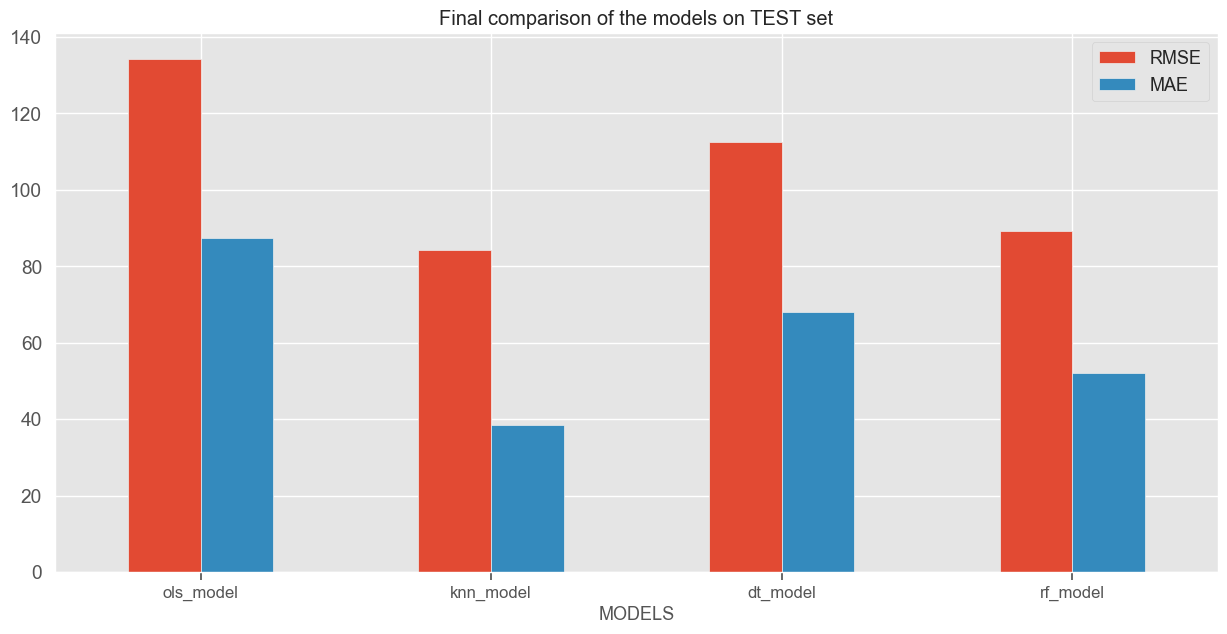

In [151]:
plt.style.use('ggplot')
ax = final_comparison.plot(kind='bar', figsize=(15, 7), title="Final comparison of the models on TEST set")
ax.legend(fontsize=13)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True, ) # labels along the bottom edge are off
ax.set_xticklabels(final_comparison.index, rotation=0, fontsize=12)
ax.set_xlabel("MODELS", fontsize=13)
ax.plot()

We see that the best performance on the test dataset was achieved by the KNN model.

## Model trained for each city - Model Evaluation

Applied similar approach for each city dataset we ended up with 4 champion model from each category for each category.

In [109]:
model_barcelona_ols = pickle.load(open("models/model_barcelona.sav", "rb"))
model_barcelona_knn = pickle.load(open("models/model_barcelona_knn.sav", "rb"))
model_barcelona_dt = pickle.load(open("models/model_barcelona_dt.sav", "rb"))
model_barcelona_rf = pickle.load(open("models/model_barcelona_rf.sav", "rb"))

model_paris_ols = pickle.load(open("models/model_paris.sav", "rb"))
model_paris_knn = pickle.load(open("models/model_paris_knn.sav", "rb"))
model_paris_dt = pickle.load(open("models/model_paris_dt.sav", "rb"))
model_paris_rf = pickle.load(open("models/model_paris_rf.sav", "rb"))

model_rome_ols = pickle.load(open("models/model_rome.sav", "rb"))
model_rome_knn = pickle.load(open("models/model_rome_knn.sav", "rb"))
model_rome_dt = pickle.load(open("models/model_rome_dt.sav", "rb"))
model_rome_rf = pickle.load(open("models/model_rome_rf.sav", "rb"))

### Barcelona
1. OLS

In [110]:
X= ['room_type', 'person_capacity', 'host_is_superhost', 'biz',
       'cleanliness_rating', 'bedrooms', 'dist', 'lng', 'is_weekend',
       'longitude_disc_2_093_2_161']
y_pred_bar_ols = model_barcelona_ols.predict(df_barcelona_test.loc[:, X].values)
y_true_bar = df_barcelona_test.realsum_cut.tolist()
rmse = np.sqrt(mean_squared_error(y_true_bar, y_pred_bar_ols))
mae = mean_absolute_error(y_true_bar, y_pred_bar_ols)
bar_ols_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [111]:
bar_ols_model_score.rename(index = {0:"bar_ols_model"}, inplace=True)
bar_ols_model_score

RMSE        MAE
bar_ols_model  115.49147  78.231169

2. KNN

In [112]:
X = ['room_type', 'room_private', 'person_capacity', 'host_is_superhost',
       'multi', 'biz', 'dist', 'metro_dist', 'lng', 'lat',
       'longitude_disc_2_093_2_161', 'longitude_disc_2_161_2_177',
       'latitude_disc_2_161_2_177']
y_pred_bar_knn = model_barcelona_knn.predict(df_barcelona_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true_bar, y_pred_bar_knn))
mae = mean_absolute_error(y_true_bar, y_pred_bar_knn)
bar_knn_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [113]:
bar_knn_model_score.rename(index = {0:"bar_knn_model"}, inplace=True)
bar_knn_model_score

RMSE        MAE
bar_knn_model  104.377199  59.528062

3. Decision Tree

In [115]:
X = ['room_type', 'room_private', 'person_capacity', 'host_is_superhost',
       'multi', 'dist', 'longitude_disc_2_161_2_177']
y_pred_bar_dt = model_barcelona_dt.predict(df_barcelona_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true_bar, y_pred_bar_dt))
mae = mean_absolute_error(y_true_bar, y_pred_bar_dt)
bar_dt_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [116]:
bar_dt_model_score.rename(index = {0:"bar_dt_model"}, inplace=True)
bar_dt_model_score

RMSE        MAE
bar_dt_model  110.310099  69.121645

4. Random Forest

In [117]:
X =['lat',
 'person_capacity',
 'lng',
 'room_private',
 'dist',
 'room_type',
 'guest_satisfaction_overall',
 'biz',
 'bedrooms',
 'metro_dist',
 'multi',
 'cleanliness_rating',
 'latitude_disc_2_161_2_177',
 'longitude_disc_2_093_2_161']
y_pred_bar_rf = model_barcelona_rf.predict(df_barcelona_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true_bar, y_pred_bar_rf))
mae = mean_absolute_error(y_true_bar, y_pred_bar_rf)
bar_rf_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [118]:
bar_rf_model_score.rename(index = {0:"bar_rf_model"}, inplace=True)
bar_rf_model_score

RMSE        MAE
bar_rf_model  94.81342  60.333266

In [146]:
final_comparison_barcelona = pd.concat([bar_ols_model_score, bar_knn_model_score, bar_dt_model_score, bar_rf_model_score])

### Paris
1. OLS

In [119]:
X = ['room_type', 'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'bedrooms', 'dist', 'lng',
       'longitude_disc_2_359_2_439']
y_pred_par_ols = model_paris_ols.predict(df_paris_test.loc[:, X].values)
y_true_par = df_paris_test.realsum_cut.tolist()
rmse = np.sqrt(mean_squared_error(y_true_par, y_pred_par_ols))
mae = mean_absolute_error(y_true_par, y_pred_par_ols)
par_ols_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [120]:
par_ols_model_score.rename(index = {0:"par_ols_model"}, inplace=True)
par_ols_model_score

RMSE         MAE
par_ols_model  163.568654  112.857965

2. KNN

In [121]:
X = ['room_type', 'person_capacity', 'multi', 'biz', 'cleanliness_rating',
       'bedrooms', 'dist', 'metro_dist', 'lng', 'lat',
       'longitude_disc_2_332_2_359', 'longitude_disc_2_359_2_439']
y_pred_par_knn = model_paris_knn.predict(df_paris_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true_par, y_pred_par_knn))
mae = mean_absolute_error(y_true_par, y_pred_par_knn)
par_knn_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [122]:
par_knn_model_score.rename(index = {0:"par_knn_model"}, inplace=True)
par_knn_model_score

RMSE        MAE
par_knn_model  109.971866  48.786425

3. Decision Tree

In [124]:
X = ['room_type', 'person_capacity', 'multi', 'biz', 'cleanliness_rating',
       'bedrooms', 'lng', 'lat', 'longitude_disc_2_248_2_332',
       'longitude_disc_2_359_2_439', 'latitude_disc_2_332_2_359']
y_pred_par_dt = model_paris_dt.predict(df_paris_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true_par, y_pred_par_dt))
mae = mean_absolute_error(y_true_par, y_pred_par_dt)
par_dt_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [125]:
par_dt_model_score.rename(index = {0:"par_dt_model"}, inplace=True)
par_dt_model_score

RMSE         MAE
par_dt_model  171.673631  109.431661

4. Random Forest

In [126]:
X = ['lng',
 'dist',
 'person_capacity',
 'lat',
 'bedrooms',
 'guest_satisfaction_overall',
 'metro_dist',
 'biz',
 'longitude_disc_2_359_2_439',
 'room_type',
 'room_private',
 'latitude_disc_2_332_2_359',
 'longitude_disc_2_332_2_359',
 'cleanliness_rating',
 'longitude_disc_2_248_2_332',
 'latitude_disc_2_248_2_332',
 'latitude_disc_2_359_2_439',
 'is_weekend',
 'multi',
 'host_is_superhost']
y_pred_par_rf = model_paris_rf.predict(df_paris_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true_par, y_pred_par_rf))
mae = mean_absolute_error(y_true_par, y_pred_par_rf)
par_rf_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [127]:
par_rf_model_score.rename(index = {0:"par_rf_model"}, inplace=True)
par_rf_model_score

RMSE        MAE
par_rf_model  132.651442  86.771935

In [145]:
final_comparison_paris = pd.concat([par_ols_model_score, par_knn_model_score, par_dt_model_score, par_rf_model_score])

### Rome
1. OLS

In [128]:
X = ['room_type',
 'room_private',
 'person_capacity',
 'host_is_superhost',
 'multi',
 'biz',
 'cleanliness_rating',
 'bedrooms',
 'dist',
 'metro_dist',
 'lng',
 'lat',
 'is_weekend',
 'longitude_disc_12_401_12_471',
 'longitude_disc_12_471_12_499',
 'longitude_disc_12_499_12_583',
 'latitude_disc_12_401_12_471',
 'latitude_disc_12_471_12_499',
 'latitude_disc_12_499_12_583']
y_pred_rome_ols = model_rome_ols.predict(df_rome_test.loc[:, X].values)
y_true_rome = df_rome_test.realsum_cut.tolist()
rmse = np.sqrt(mean_squared_error(y_true_rome, y_pred_rome_ols))
mae = mean_absolute_error(y_true_rome, y_pred_rome_ols)
rome_ols_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [129]:
rome_ols_model_score.rename(index = {0:"rome_ols_model"}, inplace=True)
rome_ols_model_score

RMSE        MAE
rome_ols_model  77.482016  64.137703

2. KNN

In [130]:
X = ['lng',
 'dist',
 'lat',
 'metro_dist',
 'person_capacity',
 'room_private',
 'room_type',
 'guest_satisfaction_overall',
 'longitude_disc_12_471_12_499',
 'bedrooms',
 'latitude_disc_12_471_12_499',
 'cleanliness_rating',
 'host_is_superhost']
y_pred_rome_knn = model_rome_knn.predict(df_rome_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true_rome, y_pred_rome_knn))
mae = mean_absolute_error(y_true_rome, y_pred_rome_knn)
rome_knn_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [131]:
rome_knn_model_score.rename(index = {0:"rome_knn_model"}, inplace=True)
rome_knn_model_score

RMSE        MAE
rome_knn_model  108.205426  91.107762

3. Decision Tree

In [132]:
y_pred_rome_dt = model_rome_dt.predict(df_rome_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true_rome, y_pred_rome_dt))
mae = mean_absolute_error(y_true_rome, y_pred_rome_dt)
rome_dt_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [133]:
rome_dt_model_score.rename(index = {0:"rome_dt_model"}, inplace=True)
rome_dt_model_score

RMSE        MAE
rome_dt_model  126.851739  93.024892

4. Random Forest

In [134]:
y_pred_rome_rf = model_rome_rf.predict(df_rome_test.loc[:, X].values)
rmse = np.sqrt(mean_squared_error(y_true_rome, y_pred_rome_rf))
mae = mean_absolute_error(y_true_rome, y_pred_rome_rf)
rome_rf_model_score = pd.DataFrame([rmse,mae]).T.rename(columns ={0:"RMSE", 1:"MAE"})

In [135]:
rome_rf_model_score.rename(index = {0:"rome_rf_model"}, inplace=True)
rome_rf_model_score

RMSE        MAE
rome_rf_model  99.134684  70.995243

In [144]:
final_comparison_rome = pd.concat([rome_ols_model_score, rome_knn_model_score, rome_dt_model_score, rome_rf_model_score])

### Final Comparison - Models by City

In [153]:
final_comparison_barcelona

RMSE        MAE
bar_ols_model  115.491470  78.231169
bar_knn_model  104.377199  59.528062
bar_dt_model   110.310099  69.121645
bar_rf_model    94.813420  60.333266

[]

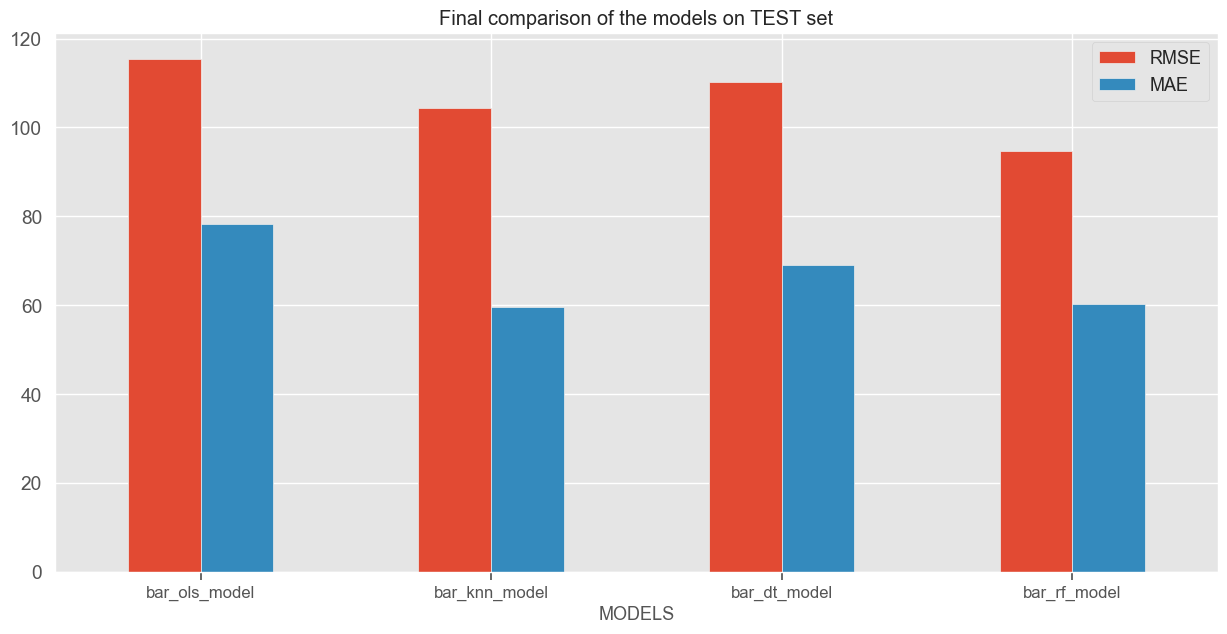

In [141]:
plt.style.use('ggplot')
ax = final_comparison_barcelona.plot(kind='bar', figsize=(15, 7), title="Final comparison of the models on TEST set")
ax.legend(fontsize=13)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True, ) # labels along the bottom edge are off
ax.set_xticklabels(final_comparison_barcelona.index, rotation=0, fontsize=12)
ax.set_xlabel("MODELS", fontsize=13)
ax.plot()

Analyzing the results we see that the best performance on the test dataset was achieved by the Random Forest model for Barcelona. However, lowest MAE was achieved by the KNN model.

In [154]:
final_comparison_paris

RMSE         MAE
par_ols_model  163.568654  112.857965
par_knn_model  109.971866   48.786425
par_dt_model   171.673631  109.431661
par_rf_model   132.651442   86.771935

[]

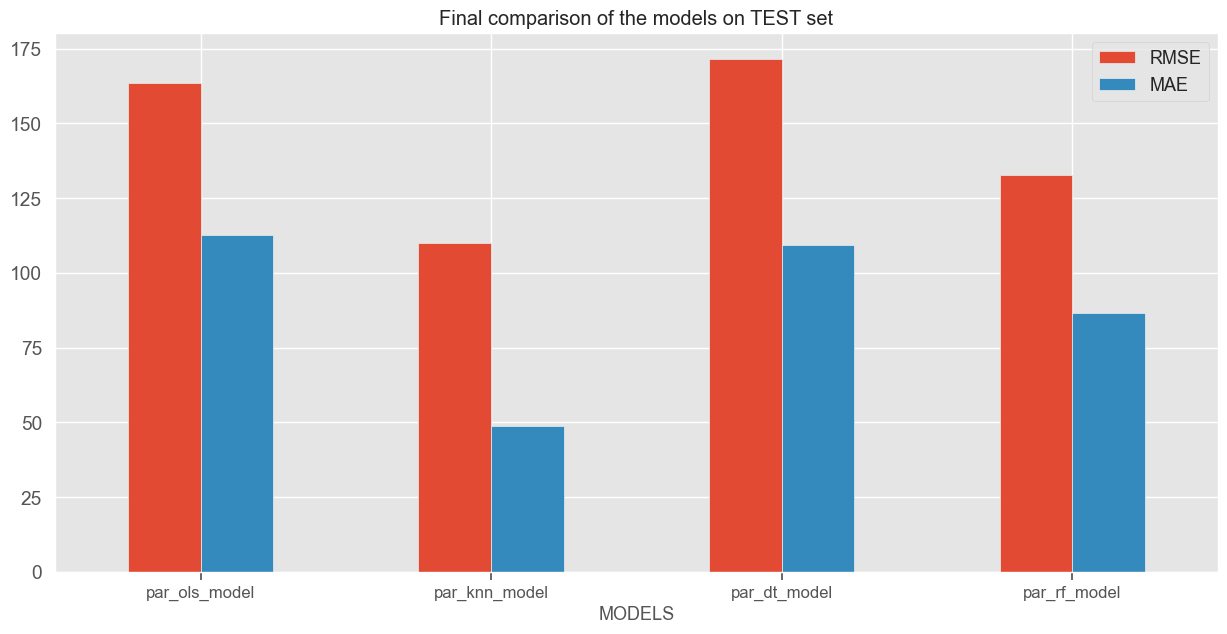

In [142]:
plt.style.use('ggplot')
ax = final_comparison_paris.plot(kind='bar', figsize=(15, 7), title="Final comparison of the models on TEST set")
ax.legend(fontsize=13)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True, ) # labels along the bottom edge are off
ax.set_xticklabels(final_comparison_paris.index, rotation=0, fontsize=12)
ax.set_xlabel("MODELS", fontsize=13)
ax.plot()

Analyzing the results we see that the best performance on the test dataset was achieved by the KNN model for Paris.

In [155]:
final_comparison_rome

RMSE        MAE
rome_ols_model   77.482016  64.137703
rome_knn_model  108.205426  91.107762
rome_dt_model   126.851739  93.024892
rome_rf_model    99.134684  70.995243

[]

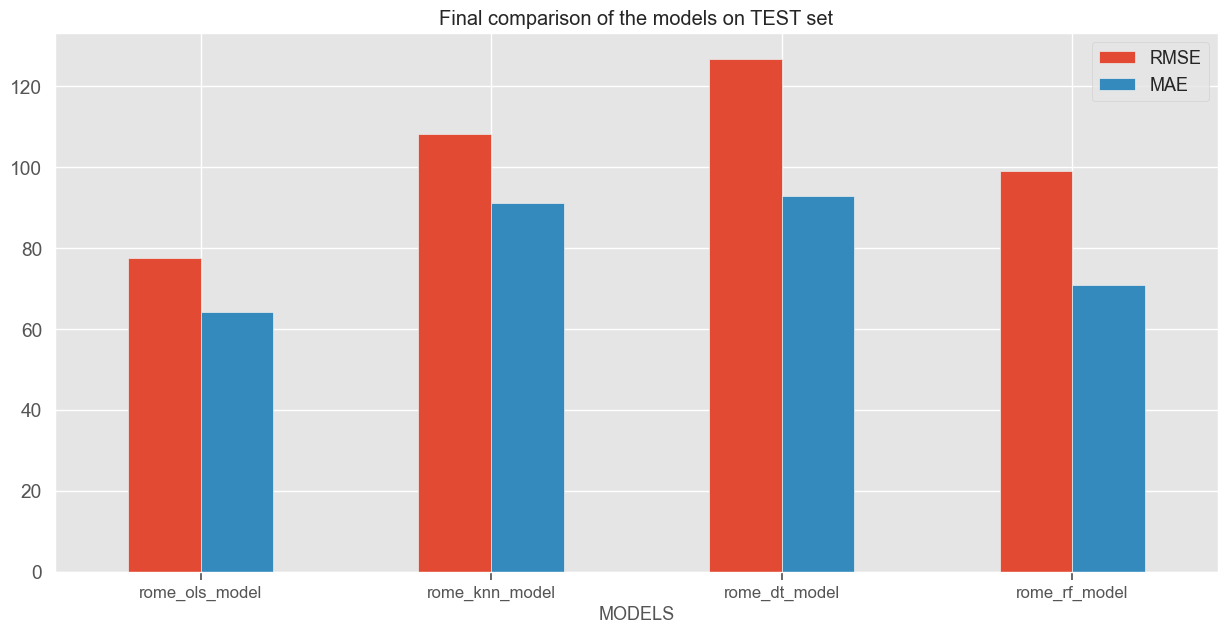

In [143]:
plt.style.use('ggplot')
ax = final_comparison_rome.plot(kind='bar', figsize=(15, 7), title="Final comparison of the models on TEST set")
ax.legend(fontsize=13)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True, ) # labels along the bottom edge are off
ax.set_xticklabels(final_comparison_rome.index, rotation=0, fontsize=12)
ax.set_xlabel("MODELS", fontsize=13)
ax.plot()

Analyzing the results we see that the best performance on the test dataset was achieved by the OLS model for Rome.

## Conclusion

In [162]:
comparison = pd.concat([knn_model_score, bar_rf_model_score, par_knn_model_score, rome_ols_model_score])
comparison.rename({"knn_model":"Global", "bar_rf_model":"Barcelona", "par_knn_model":"Paris", "rome_ols_model":"Rome"},inplace=True)

[]

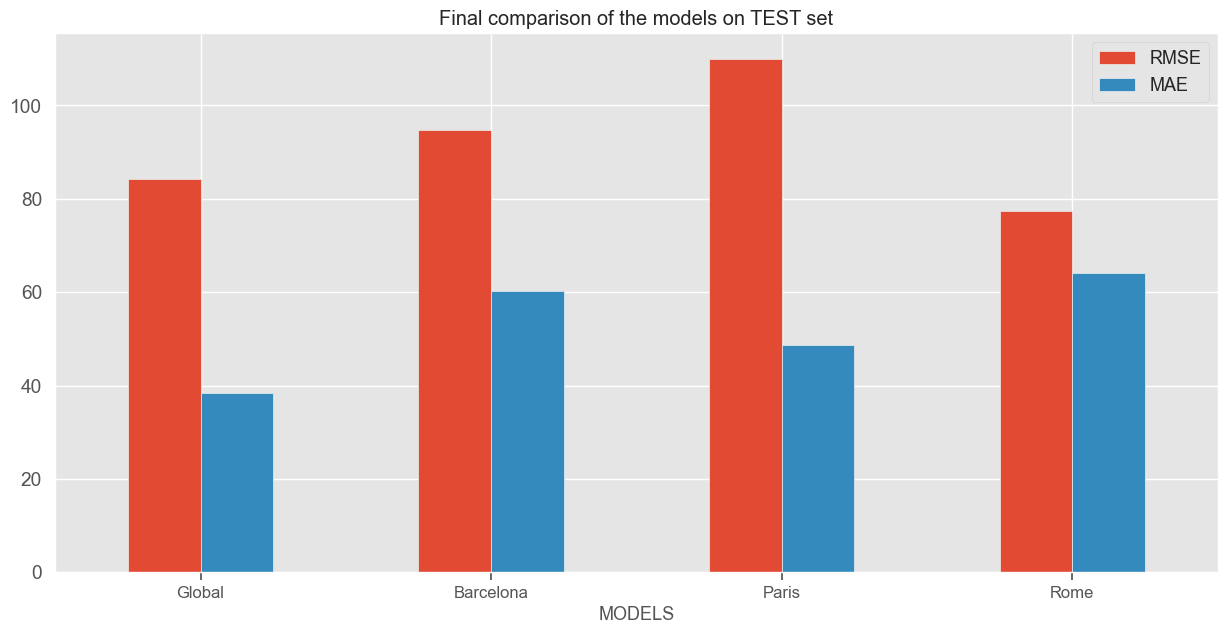

In [164]:
plt.style.use('ggplot')
ax = comparison.plot(kind='bar', figsize=(15, 7), title="Final comparison of the models on TEST set")
ax.legend(fontsize=13)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True, ) # labels along the bottom edge are off
ax.set_xticklabels(comparison.index, rotation=0, fontsize=12)
ax.set_xlabel("MODELS", fontsize=13)
ax.plot()